In [1]:
# from tensorflow.keras.models import load_model
import numpy as np
import tensorflow as tf
from neurite_sandbox.tf.models import labels_to_labels
from neurite_sandbox.tf.utils.augment import add_outside_shapes
from neurite.tf.utils.augment import draw_perlin_full

import tensorflow.keras.layers as KL
import voxelmorph as vxm


import argparse
from tensorflow.keras.callbacks import ReduceLROnPlateau
import pathlib
# import surfa as sf
import re
import json
from keras import backend as K
import param_3d
import data
import model_3d
from data_3d import *
import scipy.ndimage as ndimage

import nibabel as nib
from tqdm import tqdm

from utils import *
from help import *

/cbica/home/dadashkj/neurite/neurite/__init__.py:33: FutureWarning: The default backend will soon be changing to 'pytorch'. If you prefer to use TensorFlow, please set the NEURITE_BACKEND environment variable to 'tensorflow'.
  backend = py.utils.get_backend()
/cbica/home/dadashkj/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!


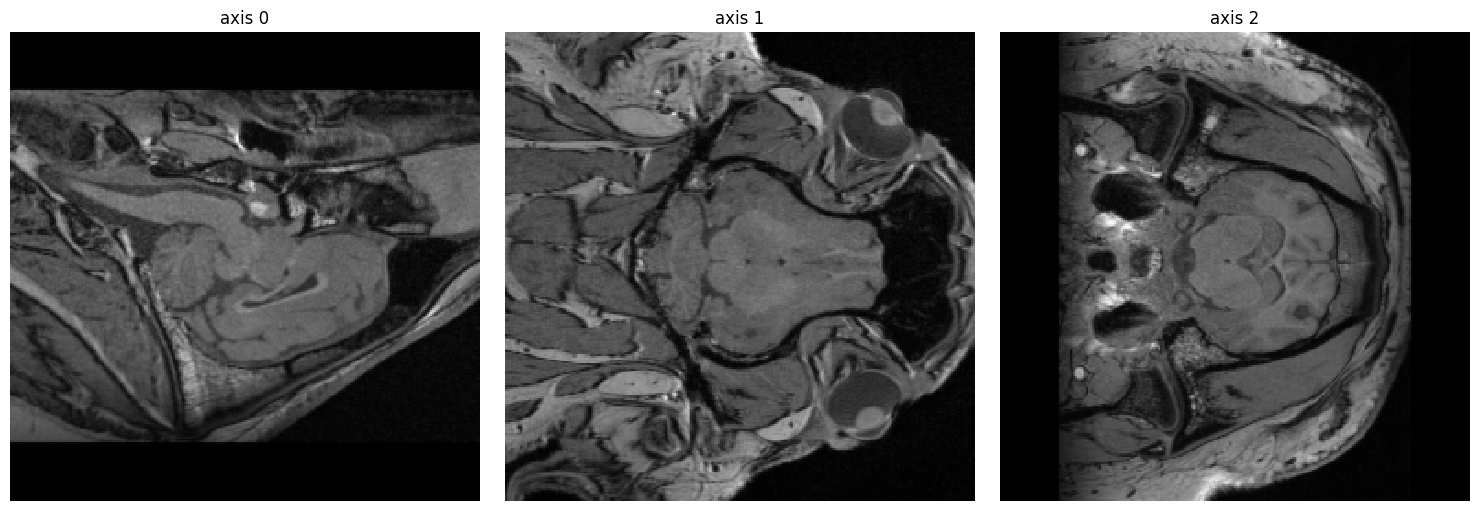

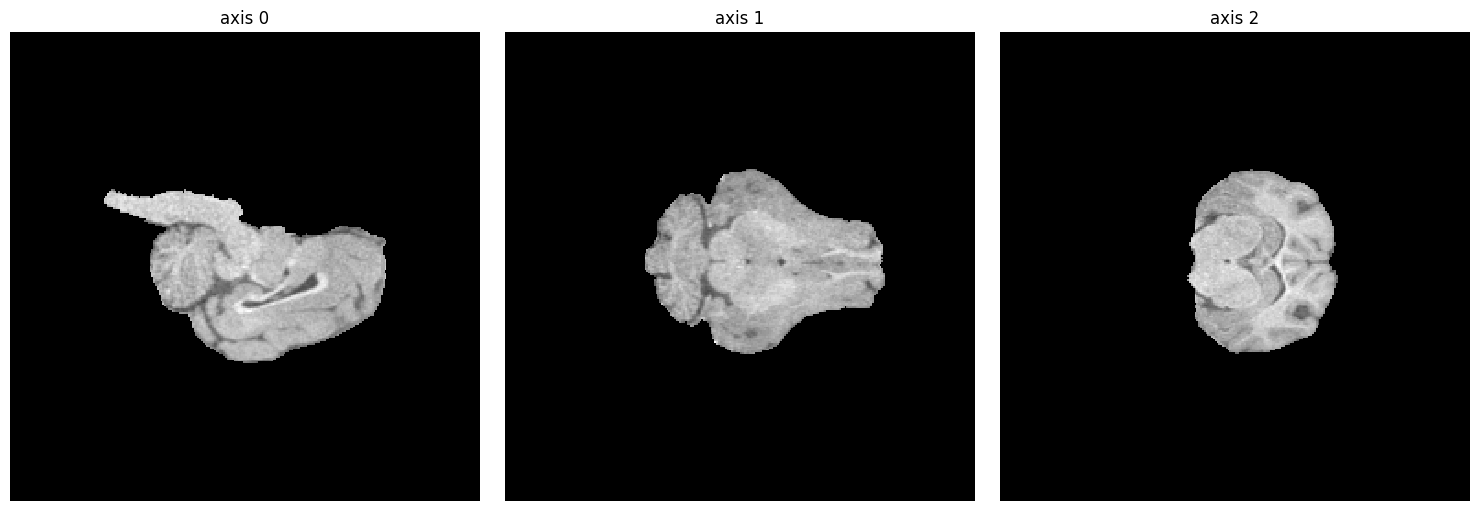

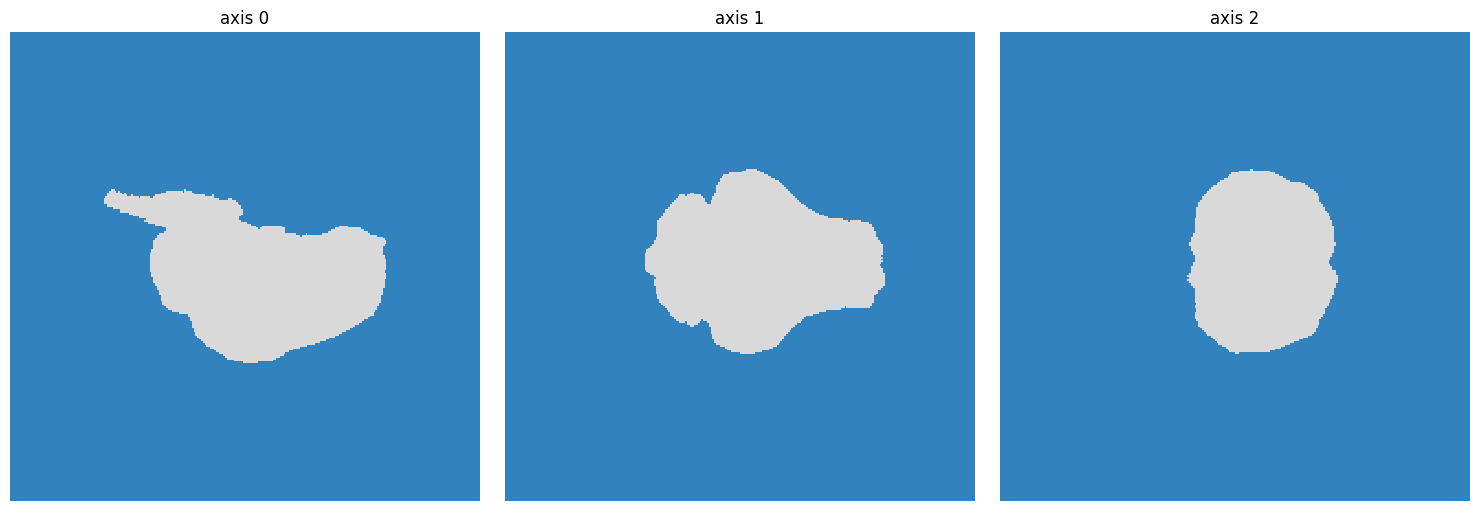

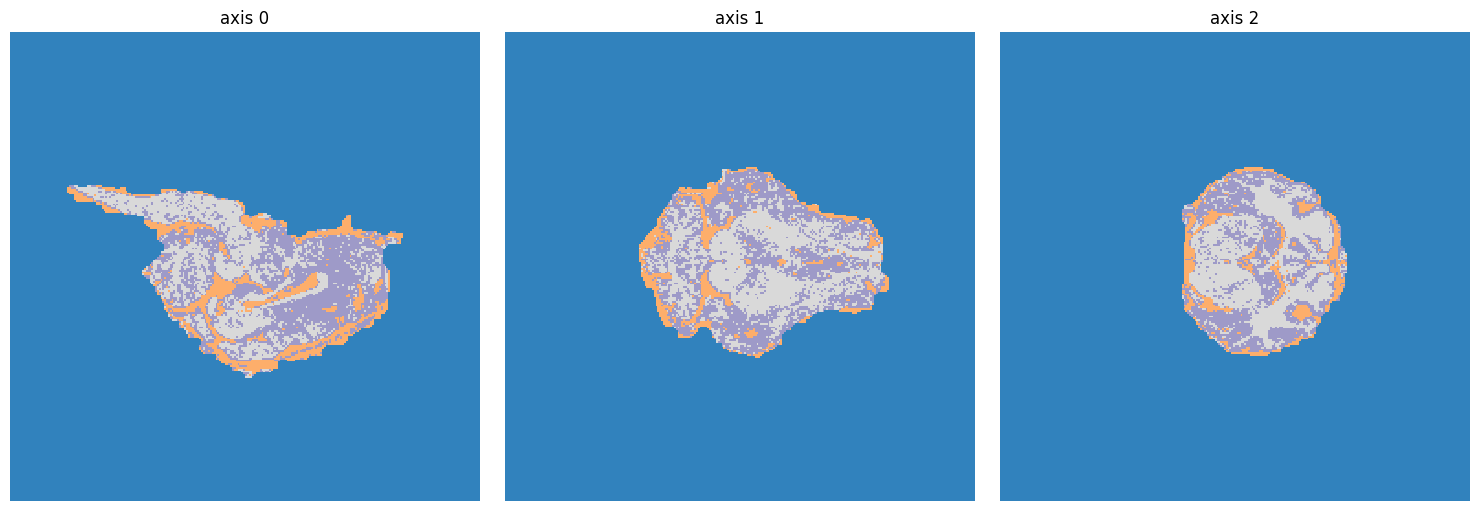

(<Figure size 1500x500 with 3 Axes>,
 [array([<AxesSubplot:title={'center':'axis 0'}>,
         <AxesSubplot:title={'center':'axis 1'}>,
         <AxesSubplot:title={'center':'axis 2'}>], dtype=object)])

In [2]:
# folder_path = "/cbica/home/dadashkj/neuroconnlab_pig_data/dwi_PigAnatomical/7646/anat"
folder_path = "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/template/"

from scipy.ndimage import zoom

def fill_holes_per_class(mask, labels=None):
    filled_mask = np.zeros_like(mask)
    if labels is None:
        labels = np.unique(mask)
        labels = labels[labels != 0]  # skip background

    for label in labels:
        class_mask = (mask == label)
        filled_class = ndi.binary_fill_holes(class_mask)
        filled_mask[filled_class] = label

    return filled_mask
    

geom_data = sf.load_volume(os.path.join(folder_path, 'anat.nii.gz')).geom
pig_seg = sf.load_volume(os.path.join(folder_path, 'fast_segmentation_seg.nii.gz')).resize(1).reshape([param_3d.img_size_256,]*3).data

pig_anat = sf.load_volume(os.path.join(folder_path, 'anat.nii.gz')).reshape([param_3d.img_size_256,]*3).data
sigma = 0.5  # Adjust sigma for desired smoothing effect
pig_anat = gaussian_filter(pig_anat, sigma=sigma)
smoothed_anat = pig_anat

pig_brain_mask = sf.load_volume(os.path.join(folder_path, 'anat_brain_olfactory_mask.nii.gz')).reshape([param_3d.img_size_256,]*3).data
pig_brain_mask = fill_holes_per_class(pig_brain_mask)



# pig_brain_mask = ndi.binary_fill_holes(pig_brain_mask)
pig_brain = pig_anat * ((pig_brain_mask == 1) | (pig_brain_mask == 2))

scaling_factor = 1
pig_anat = sf.Volume(zoom(pig_anat, scaling_factor, order=1)).reshape((256,)*3).data
pig_brain = sf.Volume(zoom(pig_brain, scaling_factor, order=1)).reshape((256,)*3).data
pig_brain_mask = sf.Volume(zoom(pig_brain_mask, scaling_factor, order=1)).reshape((256,)*3).data
pig_brain_mask = fill_holes_per_class(pig_brain_mask)

pig_seg = sf.Volume(zoom(pig_seg, scaling_factor, order=1)).reshape((256,)*3)

ne.plot.volume3D(pig_anat)
ne.plot.volume3D(pig_brain)
ne.plot.volume3D(pig_brain_mask,cmaps=['tab20c'])
ne.plot.volume3D(pig_seg,cmaps=['tab20c'])

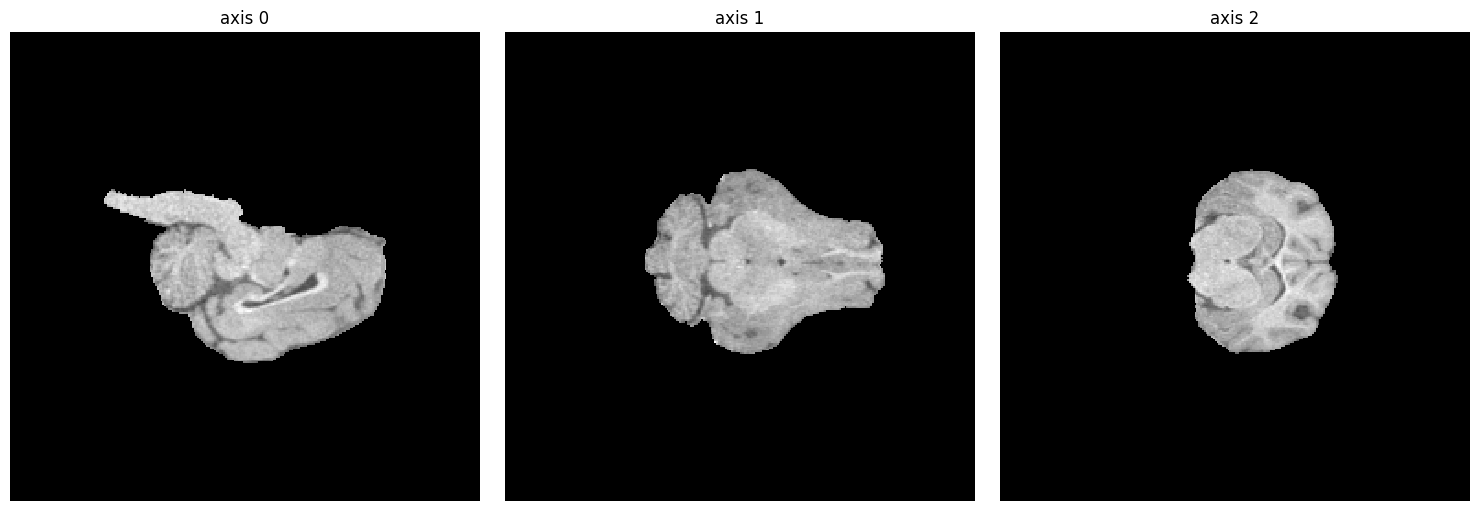

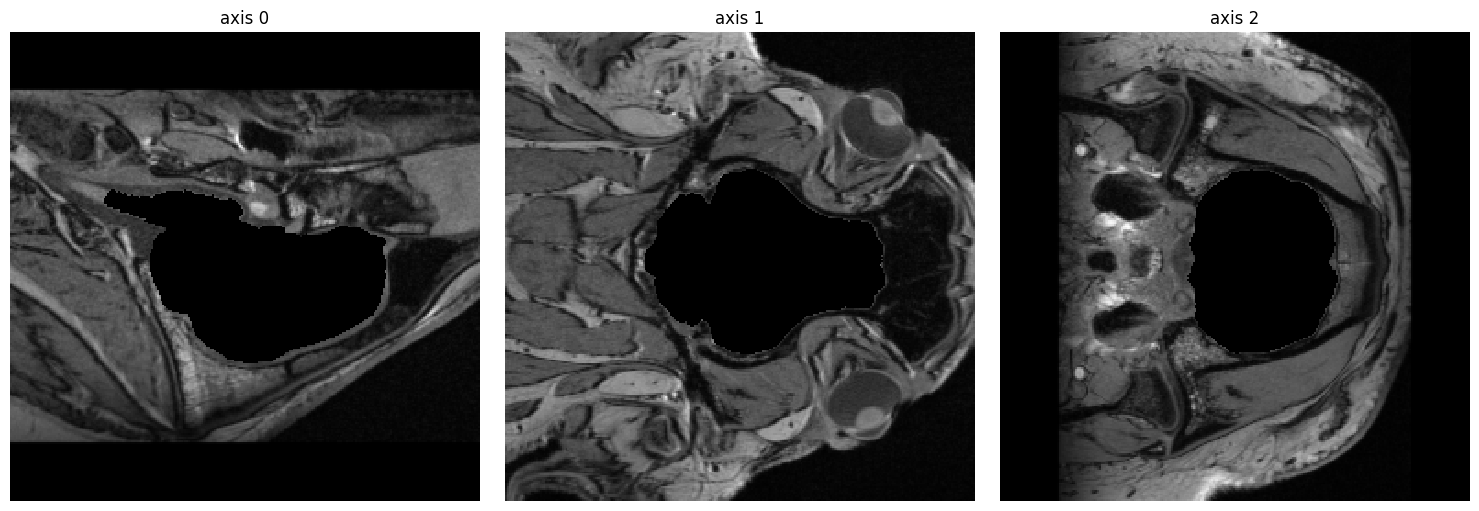

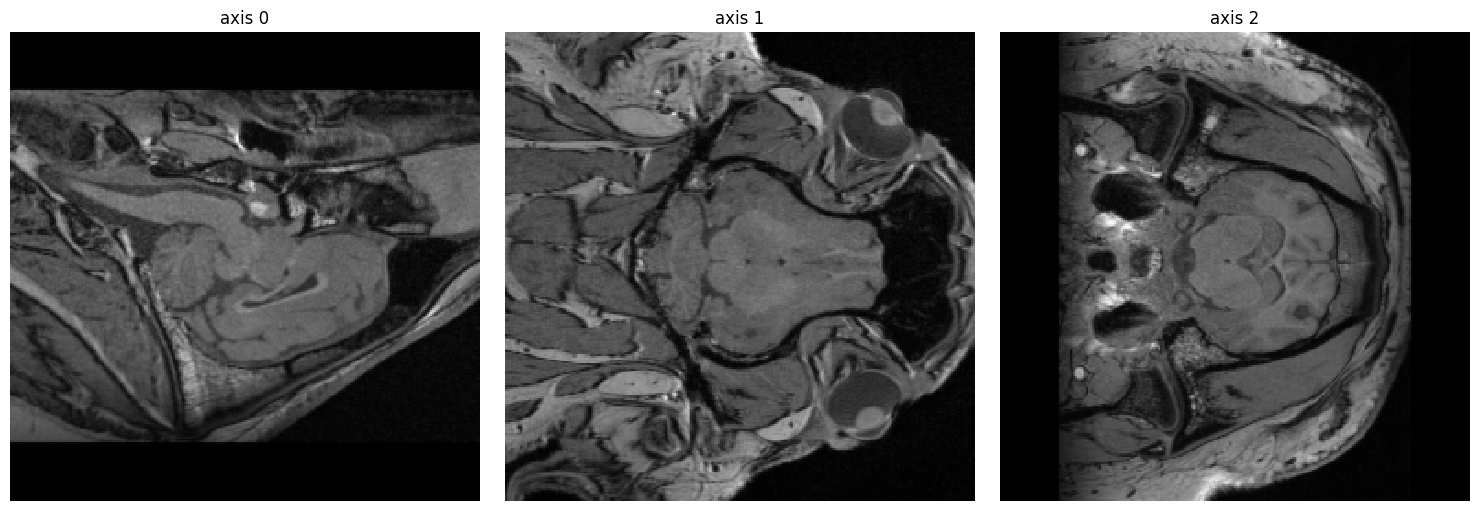

In [3]:
import numpy as np
import os
from sklearn.mixture import GaussianMixture
from scipy.ndimage import gaussian_filter
# Smooth the anatomy using Gaussian filter (with a chosen sigma)
pig_skull = np.copy(pig_anat)
pig_skull[pig_brain_mask >0] = 0
# sigma = 0.5  # Adjust sigma for desired smoothing effect
# smoothed_anat = gaussian_filter(pig_anat, sigma=sigma)
brain_data = pig_brain.flatten().reshape(-1, 1)
non_brain_data = pig_skull.flatten().reshape(-1, 1)

ne.plot.volume3D(brain_data.reshape((256,256,256)))
ne.plot.volume3D(non_brain_data.reshape((256,256,256)))
ne.plot.volume3D(smoothed_anat)

nib.save(nib.Nifti1Image(pig_anat, np.eye(4)),os.path.join("synth_data", 'pig_anat.nii.gz'))
nib.save(nib.Nifti1Image(pig_brain_mask, np.eye(4)),os.path.join("synth_data", 'pig_brain_mask.nii.gz'))

nib.save(nib.Nifti1Image(brain_data.reshape((256,256,256)), np.eye(4)),os.path.join("synth_data", 'brain_data.nii.gz'))
nib.save(nib.Nifti1Image(non_brain_data.reshape((256,256,256)), np.eye(4)),os.path.join("synth_data", 'non_brain_data.nii.gz'))
nib.save(nib.Nifti1Image(smoothed_anat.reshape((256,256,256)), np.eye(4)),os.path.join("synth_data", 'smoothed_anat.nii.gz'))

In [4]:
from scipy.ndimage import binary_dilation
from scipy.ndimage import zoom

# Define a 3D structuring element (e.g., 3x3x3 cube)
structure = np.ones((3, 3, 3), dtype=bool)


pred_192_1 = binary_dilation(pig_brain_mask, structure=structure, iterations=5)
sm = smoothed_anat.reshape((256,256,256))
print(sm.shape,pred_192_1.shape)
crop_img = sm*(pred_192_1>0)
nib.save(nib.Nifti1Image(crop_img, np.eye(4)), os.path.join("synth_data", 'dialated.nii.gz'))

(256, 256, 256) (256, 256, 256)


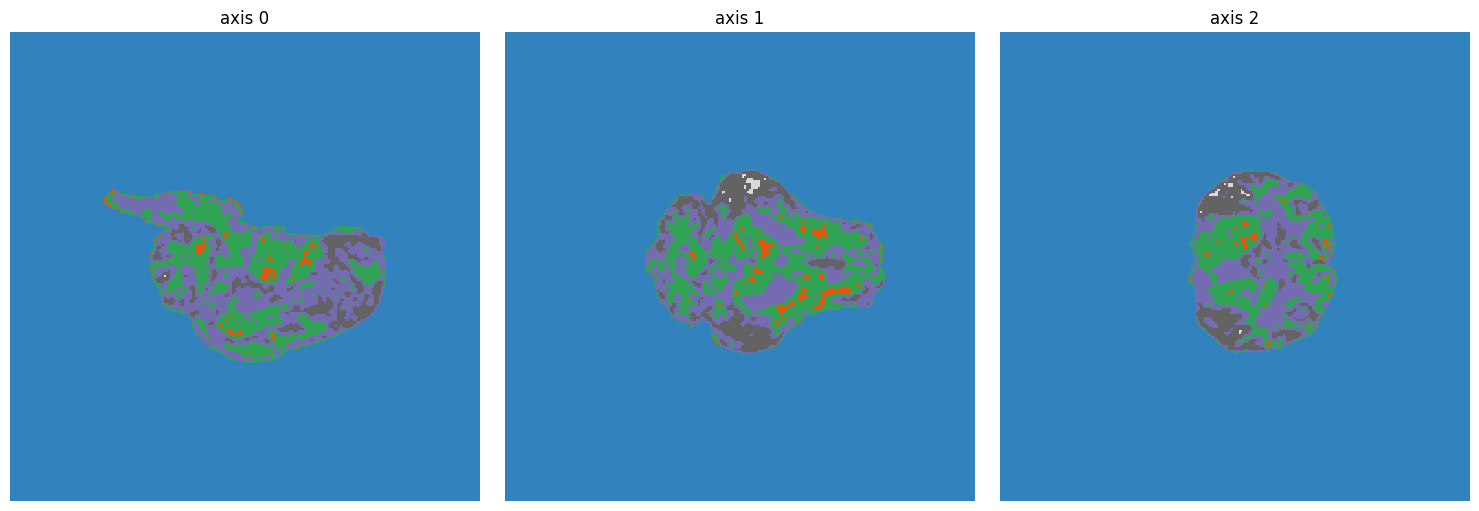

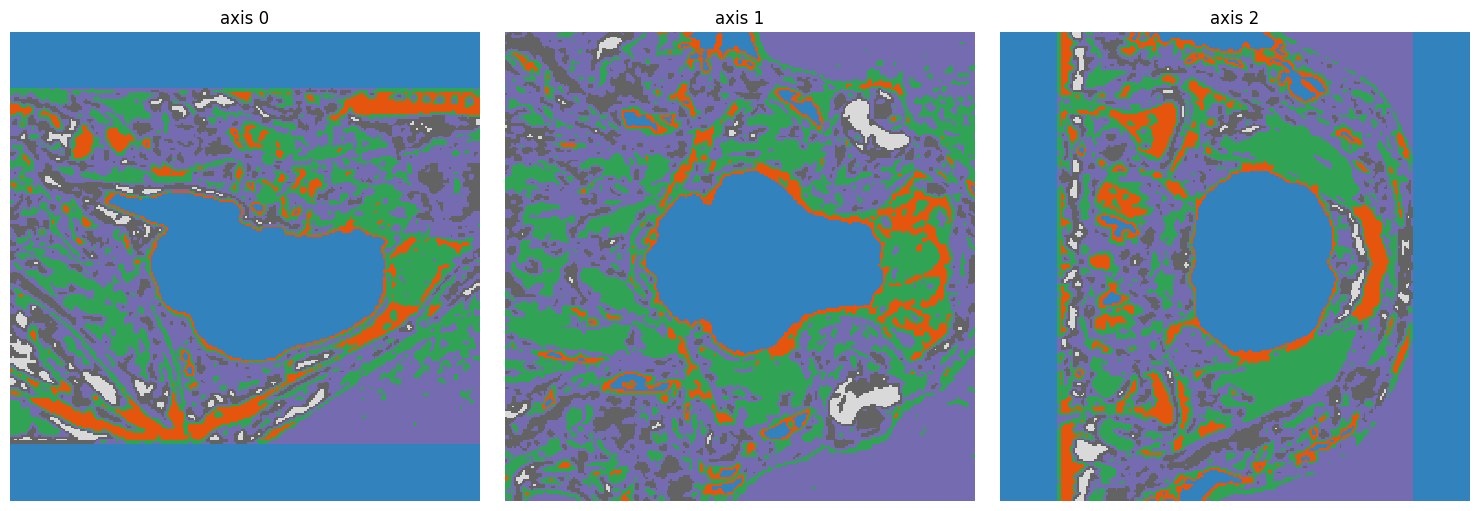

2025-05-17 17:18:13.892874: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11549 MB memory:  -> device: 0, name: NVIDIA TITAN X (Pascal), pci bus id: 0000:42:00.0, compute capability: 6.1


In [5]:
k1 = 6
k2=6

import numpy as np
np.bool = bool
from sklearn.mixture import BayesianGaussianMixture
from skimage.feature import local_binary_pattern
from scipy.ndimage import uniform_filter, generic_filter



def make_smooth(label_map):
    smoothed_labels = gaussian_filter(label_map.astype(float), sigma=2)
    return np.round(smoothed_labels).astype(int)

pig_skull = np.copy(pig_anat)
pig_skull[pig_brain_mask>0] = 0
# sigma = 0.2  # Adjust sigma for desired smoothing effect
# smoothed_anat = gaussian_filter(pig_anat, sigma=sigma)
orig_shape=pig_skull.shape
brain_data = pig_brain.flatten().reshape(-1, 1)
non_brain_data = pig_skull.flatten().reshape(-1, 1)


def make_smooth(label_map):
    smoothed_labels = gaussian_filter(label_map.astype(float), sigma=1)
    return np.round(smoothed_labels).astype(int)
    
main_brain_voxels = (pig_brain_mask == 1)
olfactory_voxels = (pig_brain_mask == 2)
non_brain_voxels = ~((pig_brain_mask == 1) | (pig_brain_mask == 2))

# --- Extract data ---
main_brain_data = pig_anat[main_brain_voxels].reshape(-1, 1)
non_brain_data = pig_anat[non_brain_voxels].reshape(-1, 1)

# --- GMM for main brain (excluding olfactory) ---
gmm_brain = GaussianMixture(n_components=k1 - 1, random_state=42)
main_brain_labels = gmm_brain.fit_predict(main_brain_data)
main_brain_labels += 1  # Shift to start from class 1

# --- GMM for non-brain tissue ---
gmm_non_brain = GaussianMixture(n_components=k2, random_state=42)
# non_brain_labels = texture_clustering_3d(pig_skull)
non_brain_labels = gmm_non_brain.fit_predict(non_brain_data)
# non_brain_labels += (k1 + 1)  # Shift to avoid overlap with brain classes

# --- Initialize label maps ---
predicted_brain_labels = np.zeros_like(pig_anat, dtype=int)
predicted_non_brain_labels = np.zeros_like(pig_anat, dtype=int)

# --- Assign labels ---
predicted_brain_labels[main_brain_voxels] = main_brain_labels
predicted_brain_labels[olfactory_voxels] = k1  # Fixed class for olfactory

predicted_non_brain_labels[non_brain_voxels] = non_brain_labels

temp_map = np.zeros_like(predicted_brain_labels)
temp_map[main_brain_voxels] = main_brain_labels  # before smoothing

smoothed_main = make_smooth(temp_map)

# --- Optional: smooth maps ---
predicted_brain_labels[main_brain_voxels] = smoothed_main[main_brain_voxels]
predicted_brain_labels[olfactory_voxels] = k1  # restore fixed class
predicted_non_brain_labels = make_smooth(predicted_non_brain_labels)
predicted_non_brain_labels[pig_anat==0]=0

# --- Reshape for plotting (if needed) ---
predicted_brain_labels = predicted_brain_labels.reshape((256, 256, 256))
predicted_non_brain_labels = predicted_non_brain_labels.reshape((256, 256, 256))

ne.plot.volume3D(predicted_brain_labels,cmaps=['tab20c'])
ne.plot.volume3D(predicted_non_brain_labels,cmaps=['tab20c'])

brain_labels = tf.cast(tf.reshape(predicted_brain_labels, (256, 256, 256)), tf.int16).numpy()
non_brain_labels = tf.cast(tf.reshape(predicted_non_brain_labels, (256, 256, 256)), tf.int16).numpy()

# Save
nib.save(nib.Nifti1Image(brain_labels, np.eye(4)), os.path.join("synth_data", 'predicted_brain_labels.nii.gz'))
nib.save(nib.Nifti1Image(non_brain_labels, np.eye(4)), os.path.join("synth_data", 'predicted_non_brain_labels.nii.gz'))

In [9]:
pig_skull.shape

(256, 256, 256)

2025-05-17 16:44:15.288451: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11549 MB memory:  -> device: 0, name: NVIDIA TITAN X (Pascal), pci bus id: 0000:42:00.0, compute capability: 6.1


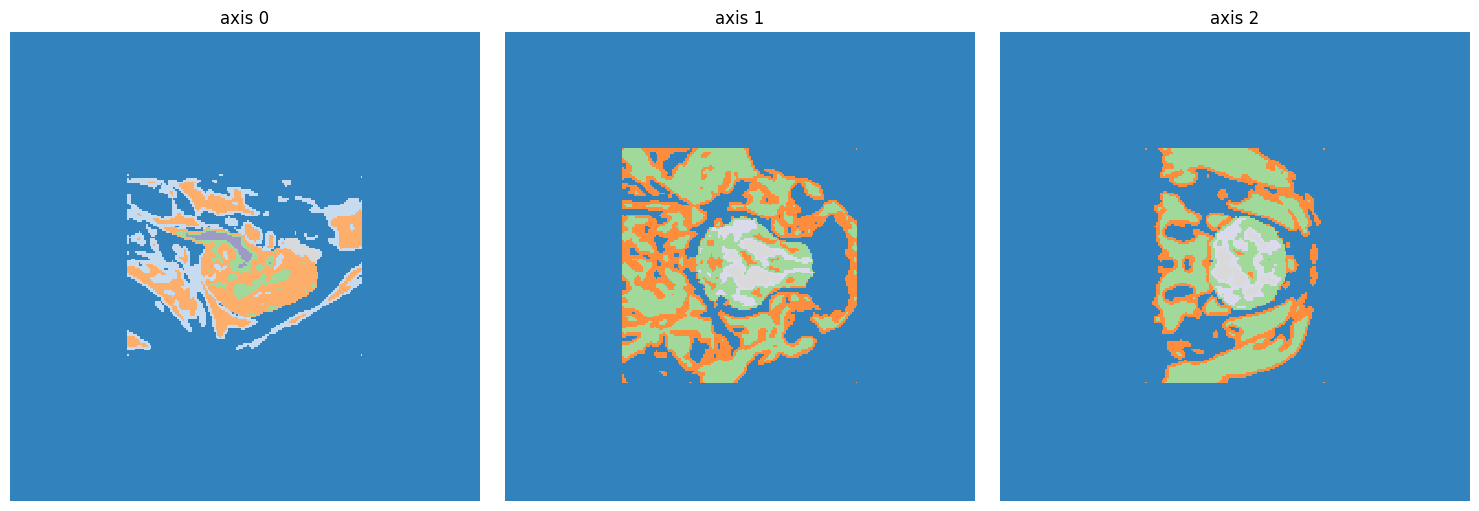

(<Figure size 1500x500 with 3 Axes>,
 [array([<AxesSubplot:title={'center':'axis 0'}>,
         <AxesSubplot:title={'center':'axis 1'}>,
         <AxesSubplot:title={'center':'axis 2'}>], dtype=object)])

In [8]:
predicted_anat_labels = np.where(predicted_brain_labels > 0, predicted_brain_labels, predicted_non_brain_labels)

ne.plot.volume3D(predicted_anat_labels,cmaps=['tab20c'])

In [9]:

# predicted_non_brain_labels[pig_brain_mask == 1] = 0
predicted_non_brain_labels = shift_non_zero_elements(predicted_non_brain_labels,7)
predicted_anat_labels = np.where(predicted_brain_labels > 0, predicted_brain_labels, predicted_non_brain_labels)


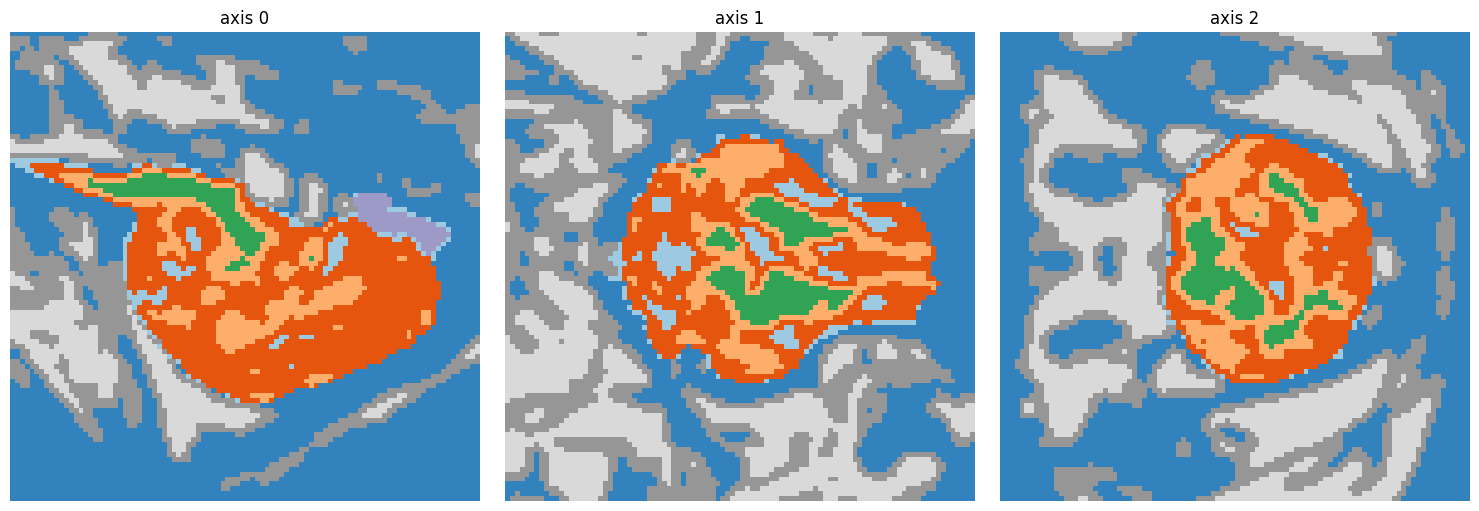

[0 8 9]
[0 1 2 3 4 6]
[0 1 2 3 4 6 8 9]


In [10]:

zoomed_predicted_anat_labels = sf.Volume(predicted_anat_labels).reshape([param_3d.img_size_96,]*3) # Use order=1 for bilinear interpolation
        
pig_brain_map = [zoomed_predicted_anat_labels]
# ne.plot.volume3D(predicted_non_brain_labels,cmaps=['tab20c'])
# ne.plot.volume3D(predicted_brain_labels,cmaps=['tab20c'])
# ne.plot.volume3D(predicted_anat_labels,cmaps=['tab20c'])
ne.plot.volume3D(zoomed_predicted_anat_labels,cmaps=['tab20c'])

print(np.unique(predicted_non_brain_labels))
print(np.unique(predicted_brain_labels))
print(np.unique(predicted_anat_labels))
nib.save(nib.Nifti1Image(zoomed_predicted_anat_labels.data.astype(np.int32), np.eye(4)), os.path.join("synth_data", '96.nii.gz'))

In [11]:
with open("params_gmm_seg_96.json", "r") as json_file:
    config = json.load(json_file)
# pig_brain_map = [predicted_anat_labels]
gen=generator_brain_window_Net(pig_brain_map,param_3d.img_size_96)



model_pig_config = config["pig_48"]
model_shapes_config = config["shapes"]
model3_config = config["labels_to_image_model_48"]
model3_config["labels_out"] = {int(key): value for key, value in model3_config["labels_out"].items()}
model3_config["in_shape"]=[ param_3d.img_size_96, param_3d.img_size_96, param_3d.img_size_96]
model_pig_config["in_shape"]=[ param_3d.img_size_96, param_3d.img_size_96, param_3d.img_size_96]
model_shapes_config["in_shape"]=[ param_3d.img_size_96, param_3d.img_size_96, param_3d.img_size_96]

model_pig = create_model(model_pig_config)
model_shapes = create_model(model_shapes_config)

labels_to_image_model = create_model(model3_config)

fragment = next(gen)
# _, fg = model_pig(fragment)


In [12]:
fragment.shape

(1, 96, 96, 96, 1)

In [13]:
with open("params_gmm_seg_96.json", "r") as json_file:
    config = json.load(json_file)
# pig_brain_map = [predicted_anat_labels]
gen=generator_brain_window_Net(pig_brain_map,param_3d.img_size_96)

num_forground_classes = 6
model_pig_config = config["pig_48"]
model_shapes_config = config["shapes"]
model_shapes_config["labels_in"] = [0] + list(range(7, 17))


model_pig_config["in_shape"]=[ param_3d.img_size_96, param_3d.img_size_96, param_3d.img_size_96]

model_pig_config["labels_out"] = {
    int(key): int(key) if int(key) in model_pig_config["labels_in"] else 0
    for key in model3_config["labels_out"].keys()
}

model_shapes_config["in_shape"]=[ param_3d.img_size_96, param_3d.img_size_96, param_3d.img_size_96]

model3_config = config["labels_to_image_model_48"]
all_possible_labels = list(range(0,17))  # or use np.unique(pig_seg) if available

model3_config["labels_in"] = all_possible_labels

model3_config["labels_out"] = {int(key): value for key, value in model3_config["labels_out"].items()}

model_shapes_config["labels_out"] = {
    int(key): int(key) if int(key) in model_shapes_config["labels_in"] else 0
    for key in model3_config["labels_out"].keys()
}


model3_config["in_shape"]=[ param_3d.img_size_96 , param_3d.img_size_96, param_3d.img_size_96]
model_pig = create_model(model_pig_config)
model_shapes = create_model(model_shapes_config)
shapes = draw_shapes_easy(shape = ( param_3d.img_size_96,)*3)   

2025-05-13 14:41:00.708276: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


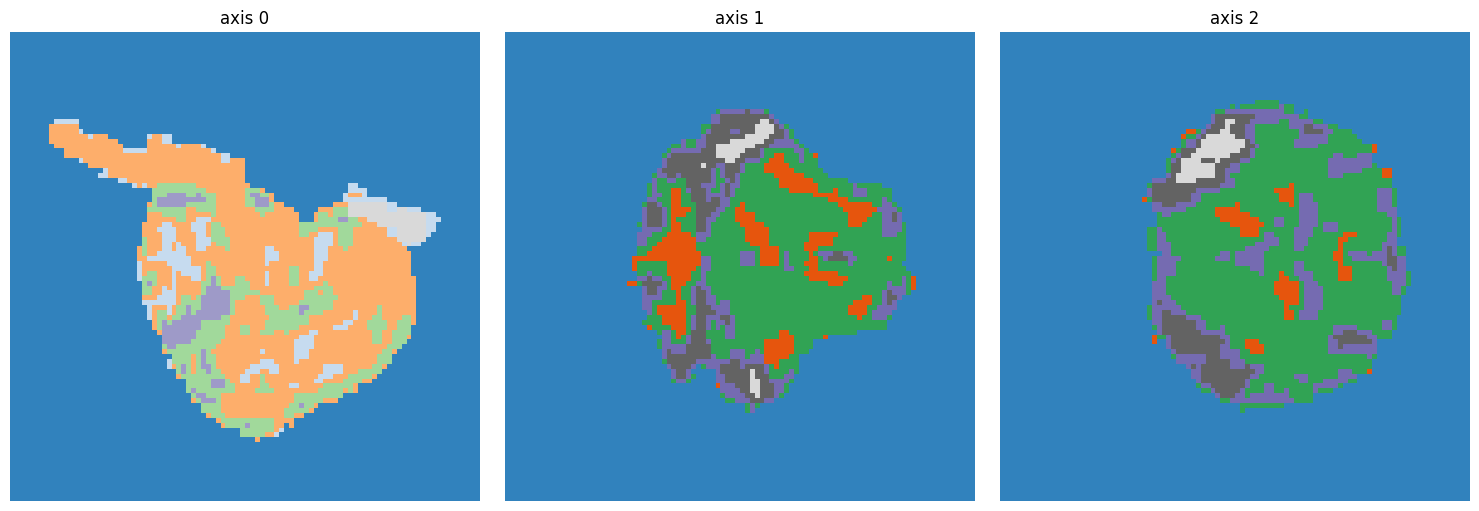

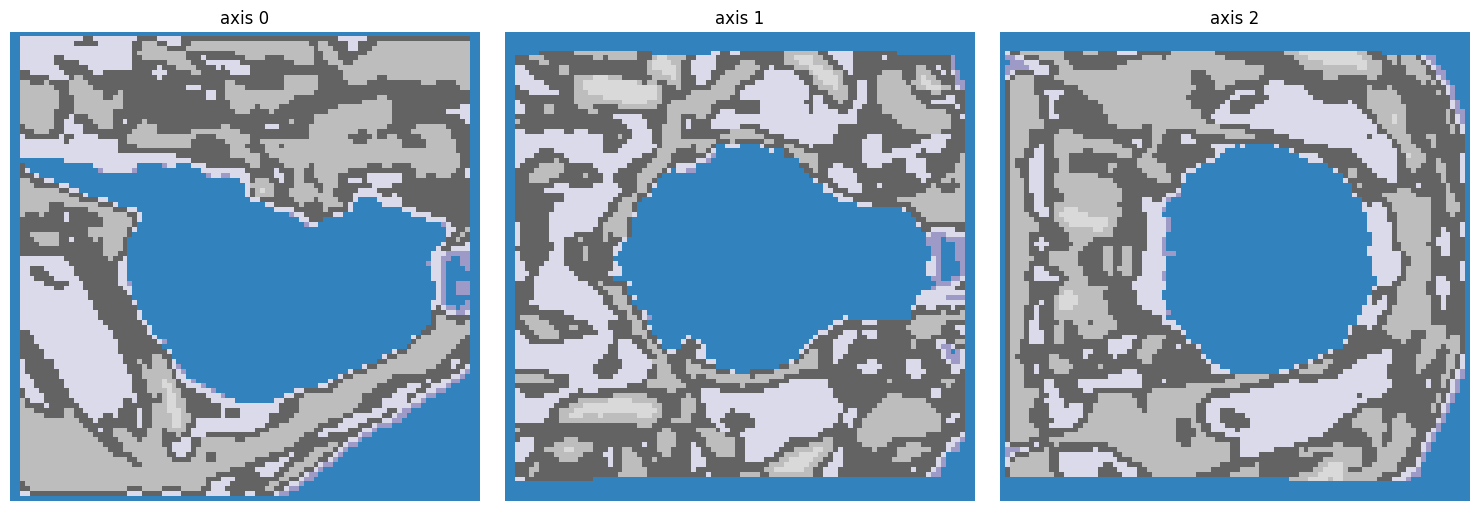

(<Figure size 1500x500 with 3 Axes>,
 [array([<AxesSubplot:title={'center':'axis 0'}>,
         <AxesSubplot:title={'center':'axis 1'}>,
         <AxesSubplot:title={'center':'axis 2'}>], dtype=object)])

In [17]:
 fragment = next(gen)
_, fg = model_pig(fragment)
_, bg = model_shapes(fragment)

result = fg[0,...,0] + bg[0,...,0] * tf.cast(fg[0,...,0] == 0,tf.int32)
result = result[None,...,None]

# fragment = next(gen)

# _, fg = model_pig(fragment)

# shapes = draw_shapes(shape = (param_3d.img_size_96,)*3,num_label=10)

# shapes = tf.squeeze(shapes)
# shapes = tf.cast(shapes, tf.int32)
# shapes = shift_non_zero_elements(shapes,6)
# _ , bg = model_shapes(shapes[None,...,None])

ne.plot.volume3D(fg[0,...,0],cmaps=['tab20c'])
ne.plot.volume3D(bg[0,...,0],cmaps=['tab20c'])

In [46]:
np.unique(fg)

array([0, 1, 2], dtype=int32)

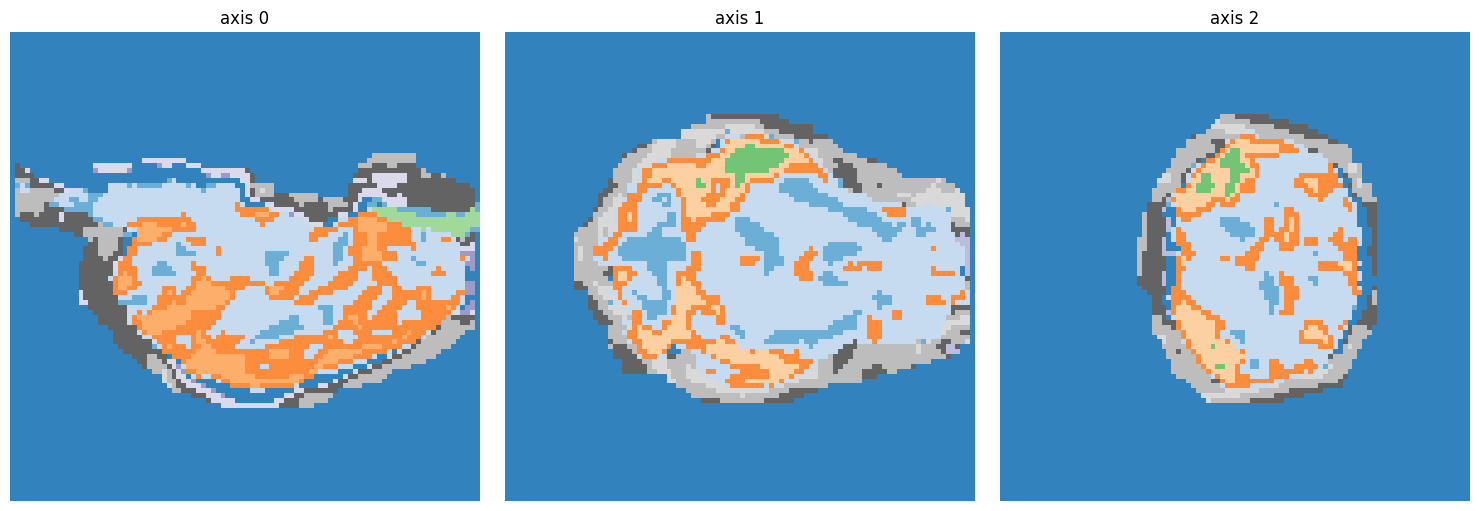

(<Figure size 1500x500 with 3 Axes>,
 [array([<AxesSubplot:title={'center':'axis 0'}>,
         <AxesSubplot:title={'center':'axis 1'}>,
         <AxesSubplot:title={'center':'axis 2'}>], dtype=object)])

In [18]:
 fragment = next(gen)
_, fg = model_pig(fragment)
_, bg = model_shapes(fragment)

result = fg[0,...,0] + bg[0,...,0] * tf.cast(fg[0,...,0] == 0,tf.int32)
result = result[None,...,None]

# fragment = next(gen)
# # fg=fragment
# shapes = draw_shapes(shape = (param_3d.img_size_96,)*3,num_label=10)

# shapes = tf.squeeze(shapes)
# shapes = tf.cast(shapes, tf.int32)
# shapes = shift_non_zero_elements(shapes,6)
# _ , bg = model_shapes(shapes[None,...,None])
# result = fg[0,...,0] +bg[0,...,0] * tf.cast(fg[0,...,0] == 0,tf.int32)
nib.save(nib.Nifti1Image(bg[0,...,0].numpy().astype(np.int32), np.eye(4)), os.path.join("synth_data", '96_bg.nii.gz'))
# result = result[None,...,None]
def mask_bg_near_fg(fg, bg, dilation_iter=3):
    fg_mask = tf.cast(fg[0, ..., 0] > 0, tf.float32)
    fg_mask = tf.expand_dims(fg_mask, axis=0)
    fg_mask = tf.expand_dims(fg_mask, axis=-1)
    fg_mask = tf.nn.max_pool3d(fg_mask, ksize=2*dilation_iter+1, strides=1, padding='SAME')
    fg_mask = tf.squeeze(fg_mask > 0)

    bg_masked = tf.where(fg_mask, bg[0, ..., 0], tf.zeros_like(bg[0, ..., 0]))
    result = tf.where(fg[0, ..., 0] > 0, fg[0, ..., 0], bg_masked)
    result = result[None, ..., None]
    return result


result = mask_bg_near_fg(fg, bg, dilation_iter=3)
nib.save(nib.Nifti1Image(result[0,...,0].numpy().astype(np.int32), np.eye(4)), os.path.join("synth_data", '96_fg_bg.nii.gz'))

ne.plot.volume3D(result[0,...,0],cmaps=['tab20c'])

In [23]:
bg.shape

TensorShape([1, 96, 96, 96, 1])

In [8]:
# a = fragment[0, ...,0] 
# fg_mask = (a >= 1) & (a <= 6)  

# fragment_brain = tf.where(fg_mask, a, 0)
# # fragment_brain = tf.where(fg_mask, 1, 0) 
# _, fg = model_pig(fragment_brain[None,...,None])
# ne.plot.volume3D(fg[0,...,0],cmaps=['tab20c'])

# a = fragment[0, ...,0] 
# bg_mask = (a > 6) | (a == 0)
# fragment_bg = tf.where(bg_mask, a, 0)
# _, bg = model_shapes(fragment_bg[None,...,None])
# ne.plot.volume3D(bg[0,...,0],cmaps=['tab20c'])

NameError: name 'fragment' is not defined

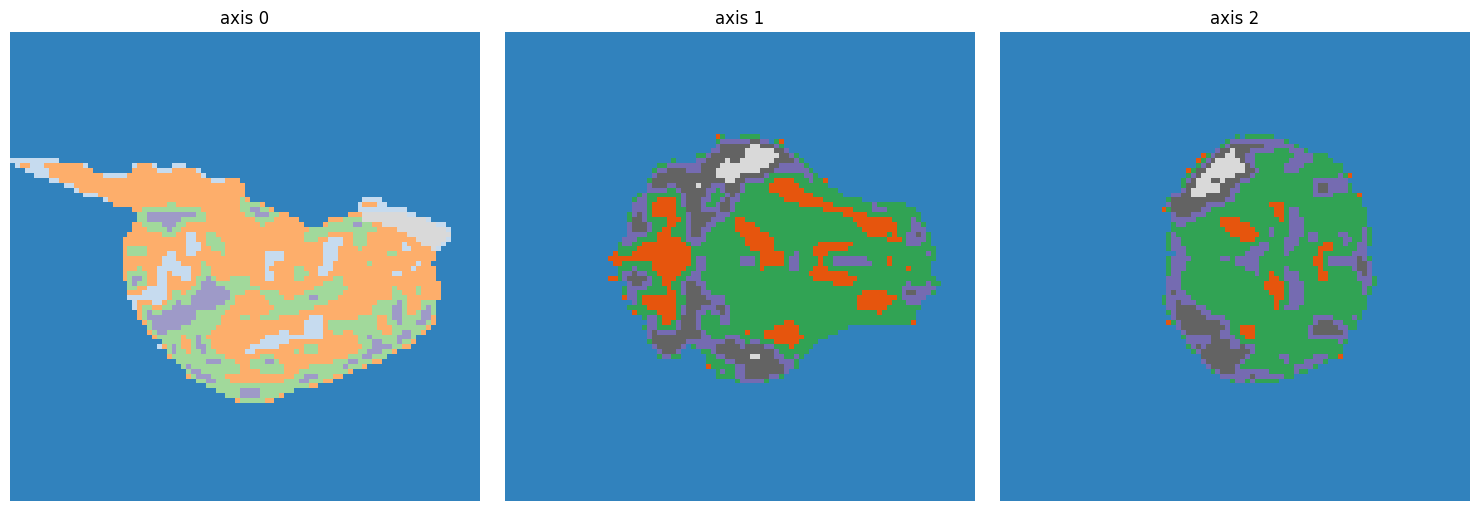

(<Figure size 1500x500 with 3 Axes>,
 [array([<AxesSubplot:title={'center':'axis 0'}>,
         <AxesSubplot:title={'center':'axis 1'}>,
         <AxesSubplot:title={'center':'axis 2'}>], dtype=object)])

In [24]:
# result = fg[0,...,0] + bg[0,...,0] * tf.cast(fg[0,...,0] == 0,tf.int32)



(1, 96, 96, 96, 1)
(96, 96, 96) 74692


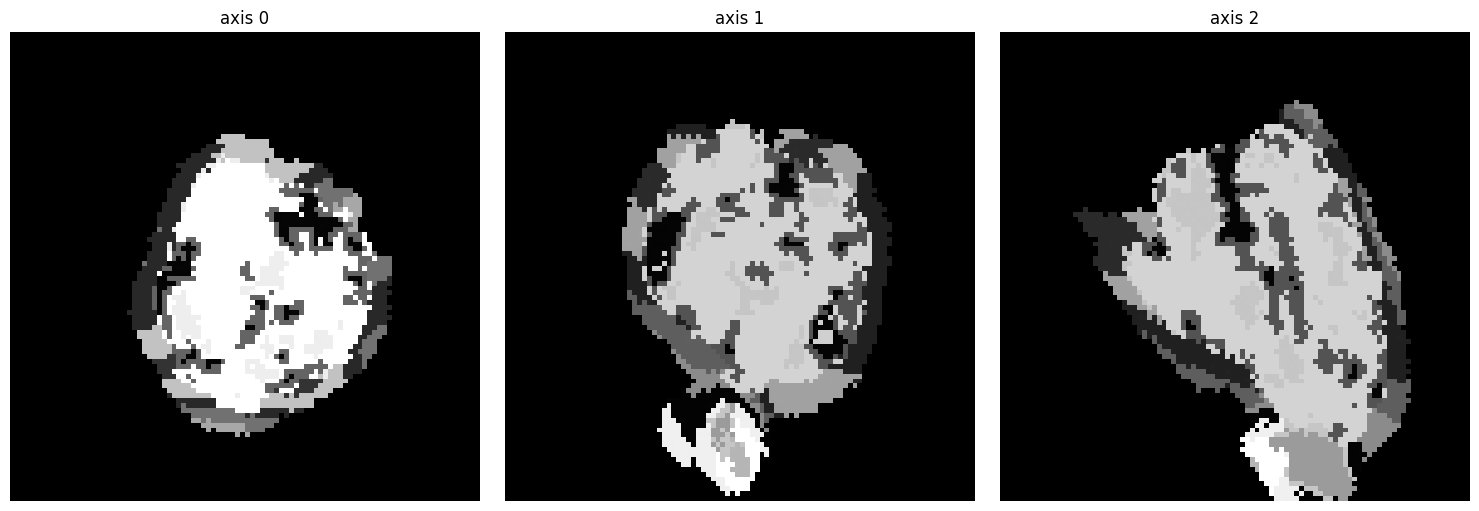

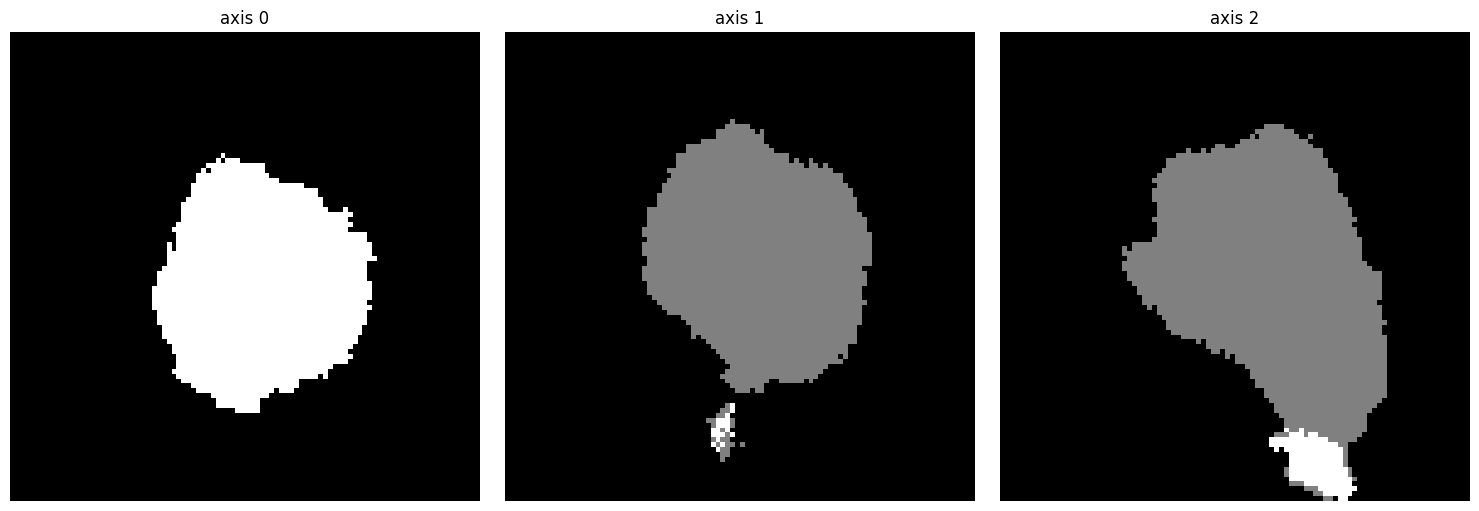

(1, 96, 96, 96, 1)
(96, 96, 96) 67806


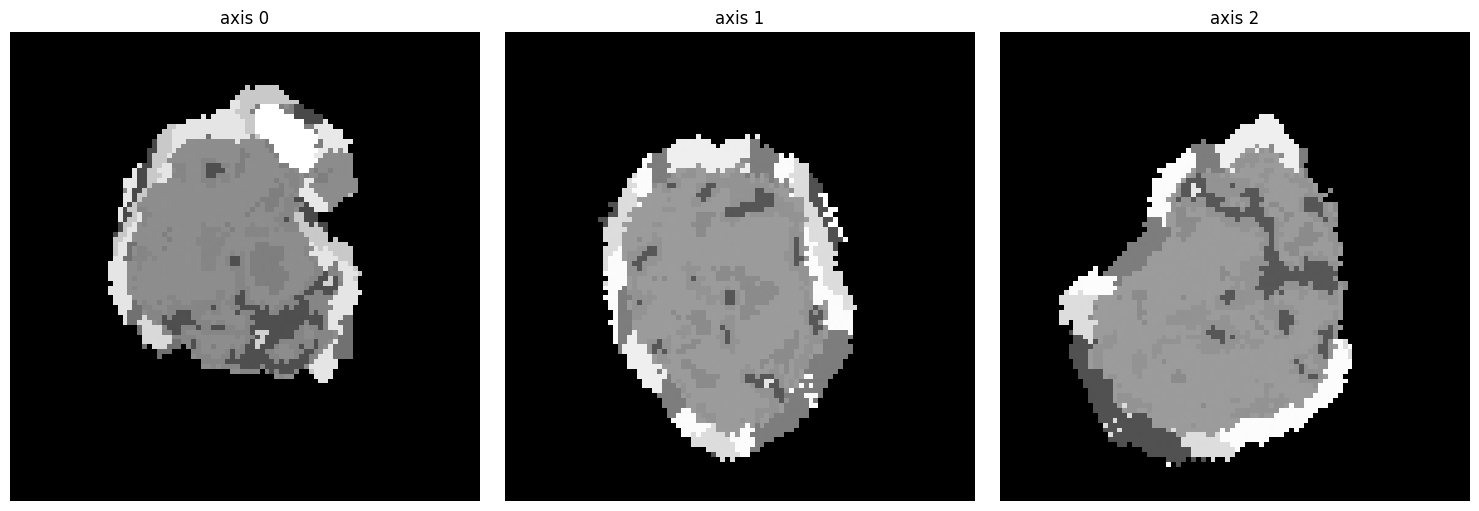

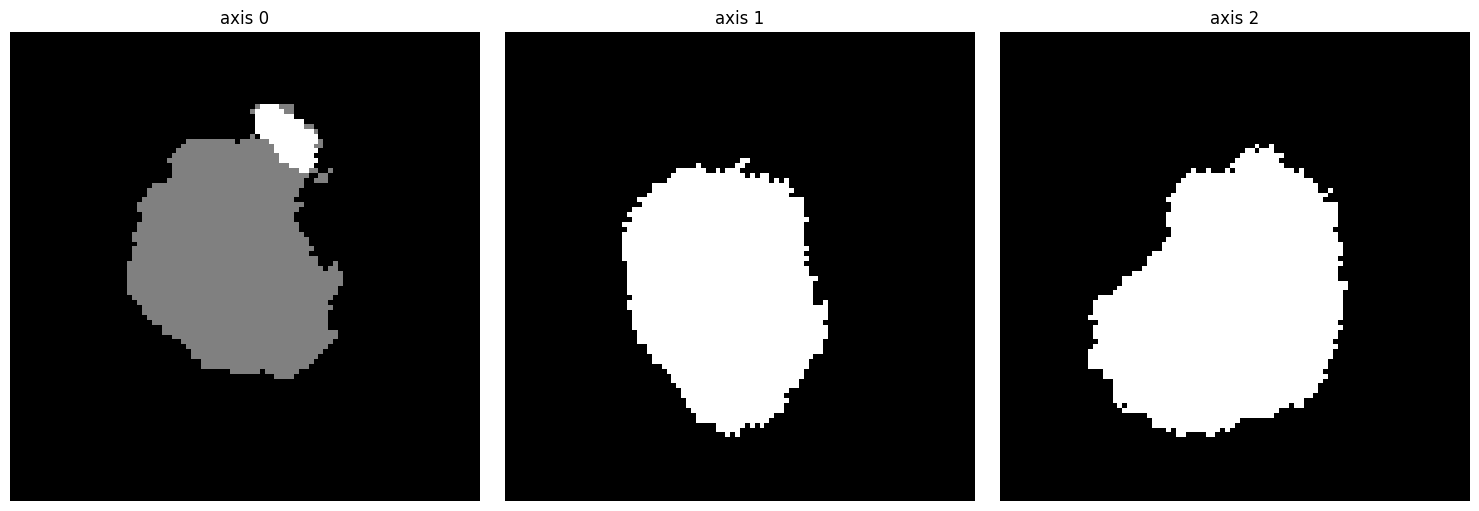

(1, 96, 96, 96, 1)
(96, 96, 96) 77609


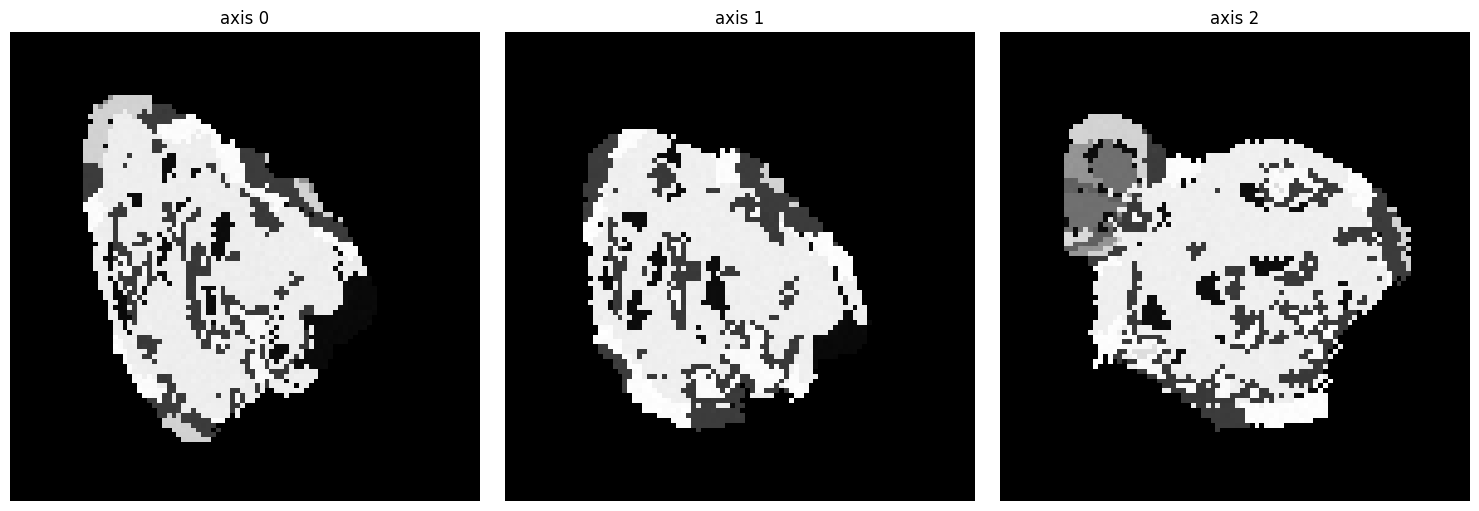

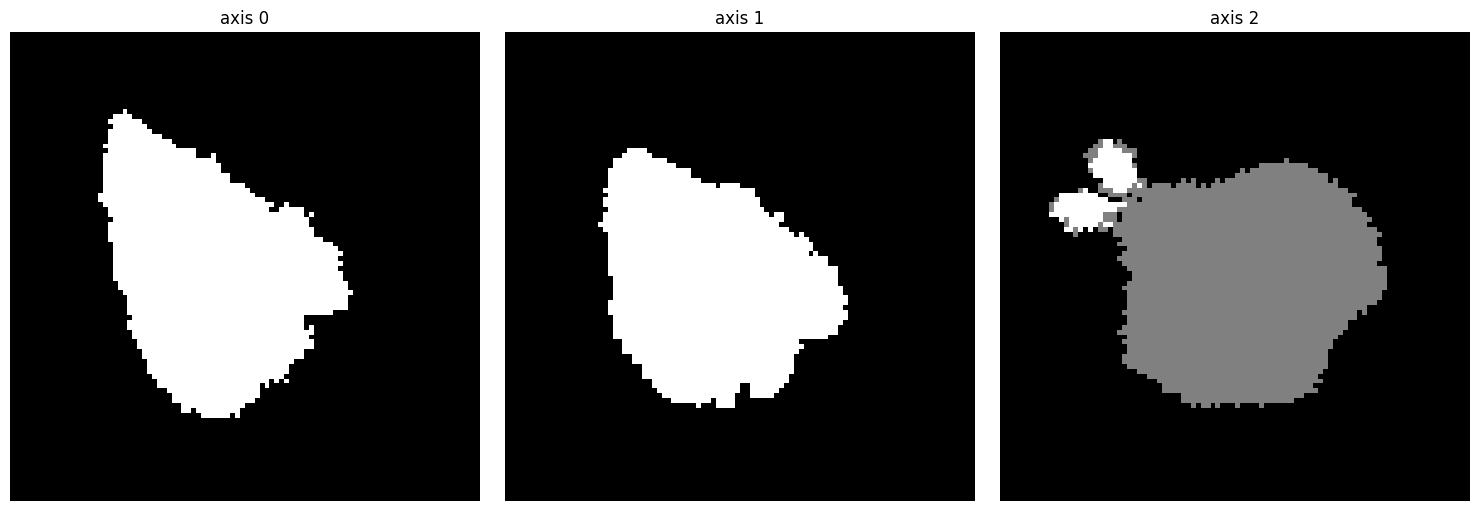

(1, 96, 96, 96, 1)
(96, 96, 96) 79956


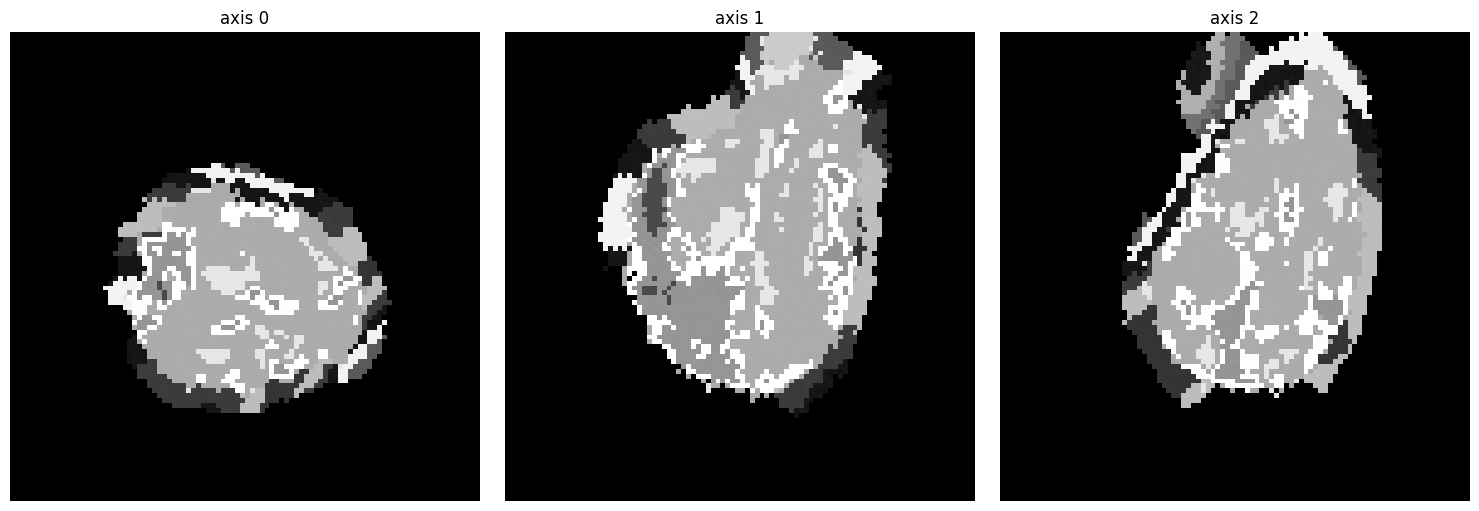

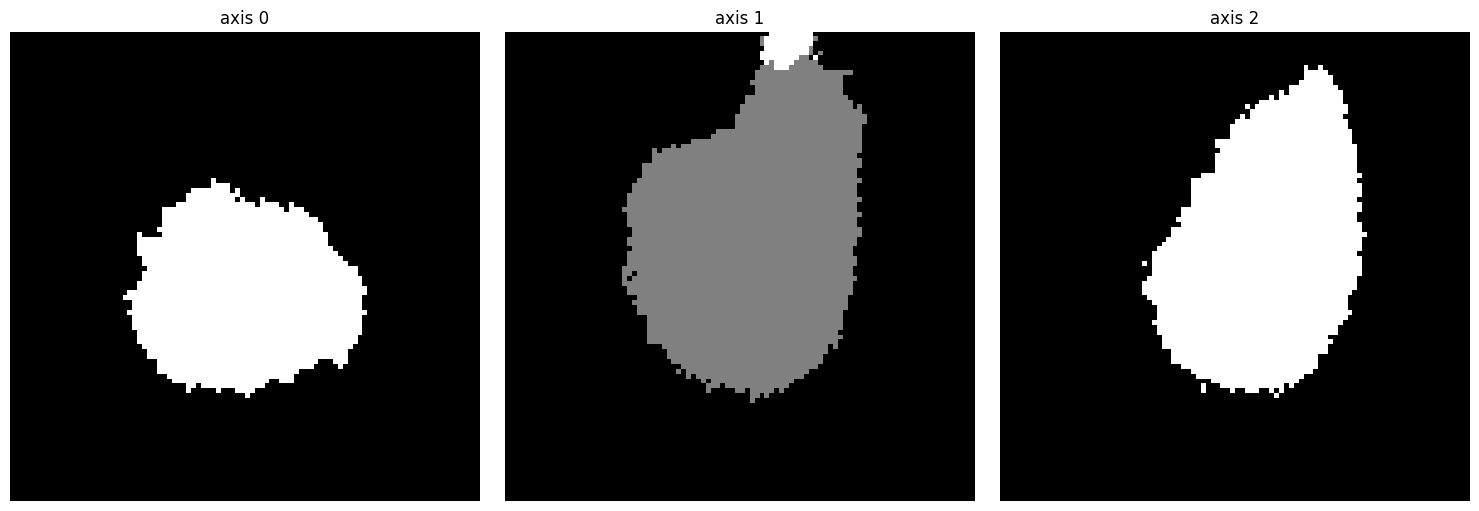

(1, 96, 96, 96, 1)
(96, 96, 96) 88072


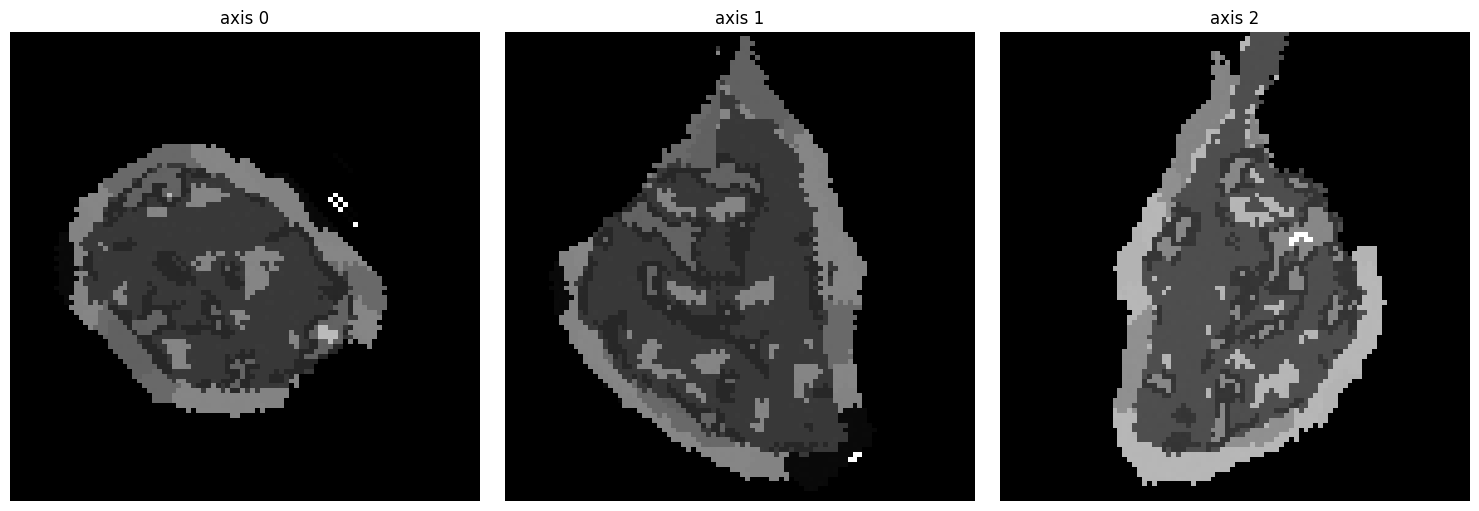

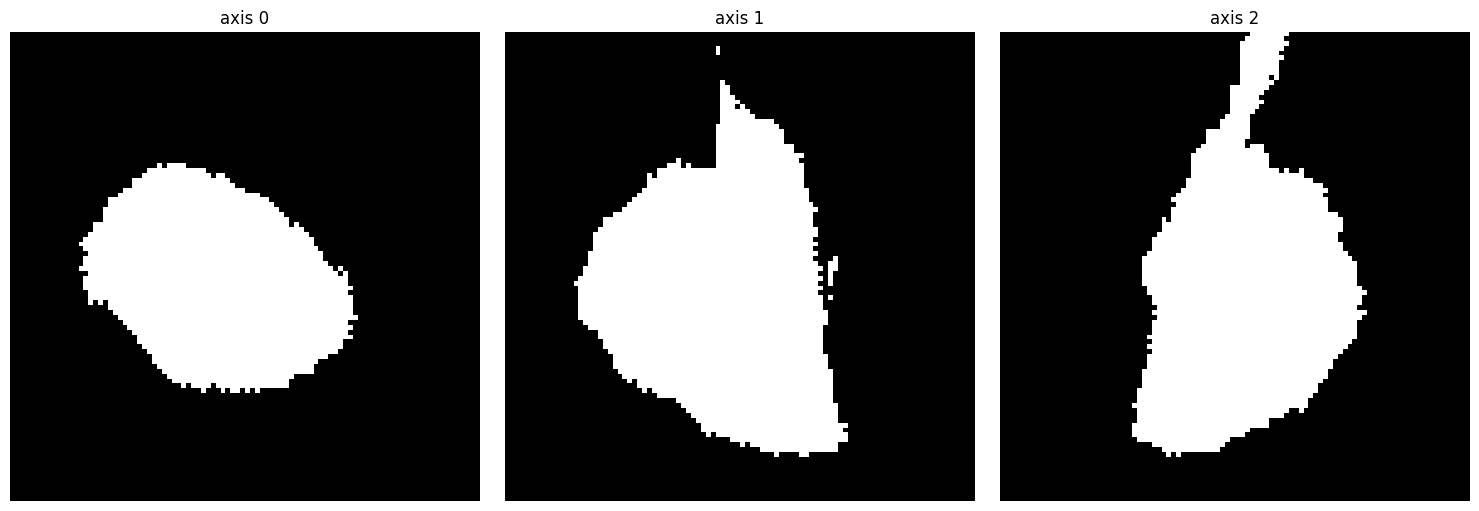

In [53]:
for i in range(5):
    labels_to_image_model = create_model(model3_config)
    generated_img, y = labels_to_image_model(result)
    
    print(generated_img.shape)
    z=np.argmax(y,axis=-1)
    ms = np.mean(np.column_stack(np.nonzero(z[0])), axis=0).astype(int)
    mask = np.argmax(y,axis=-1)[0]
    print(mask.shape,np.sum(mask))
    ne.plot.volume3D(generated_img,slice_nos=ms);
    ne.plot.volume3D(mask,slice_nos=ms);
    nib.save(nib.Nifti1Image(generated_img[0,...,0].numpy(), np.eye(4)),os.path.join("synth_data", str(i)+'_img.nii.gz'))
    nib.save(nib.Nifti1Image(mask.astype(np.int32), np.eye(4)),os.path.join("synth_data", str(i)+'_mask.nii.gz'))

In [12]:
result.shape

TensorShape([1, 96, 96, 96, 1])

[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!


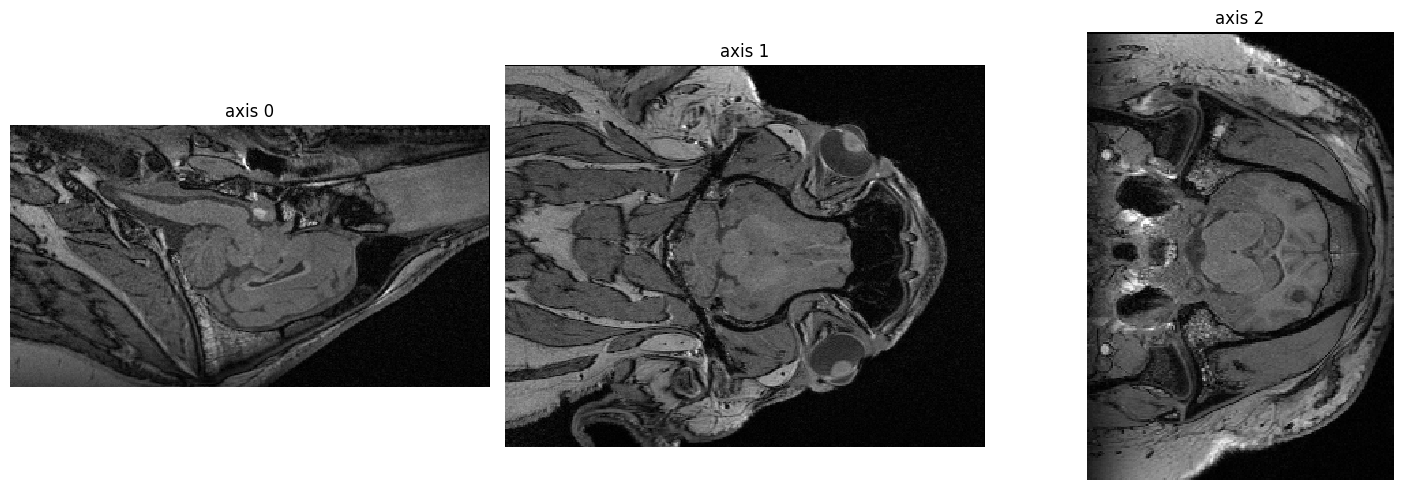

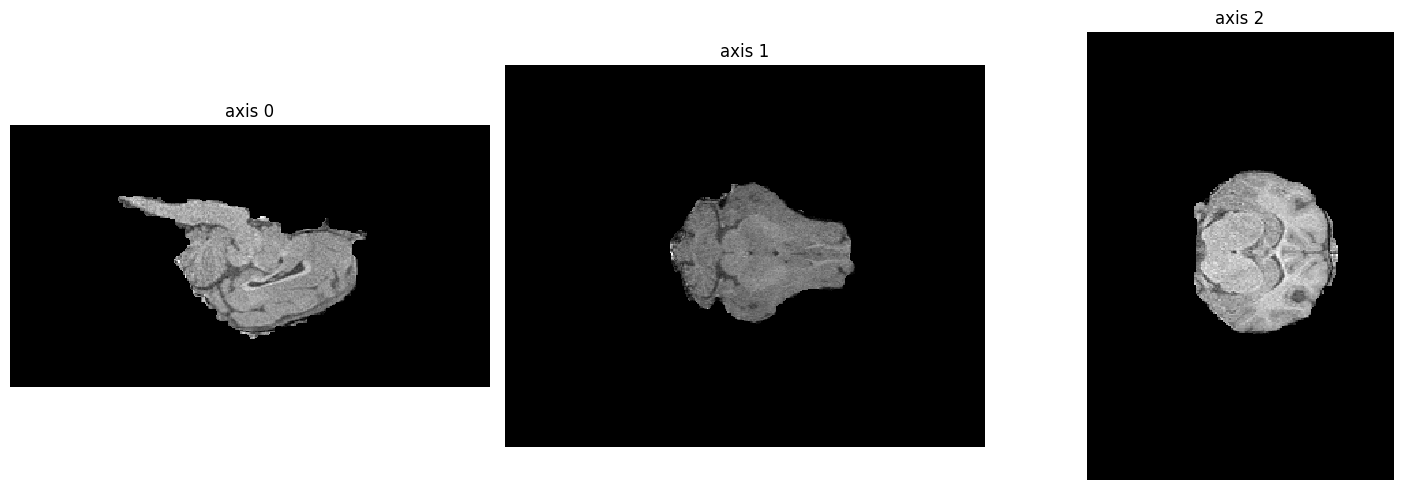

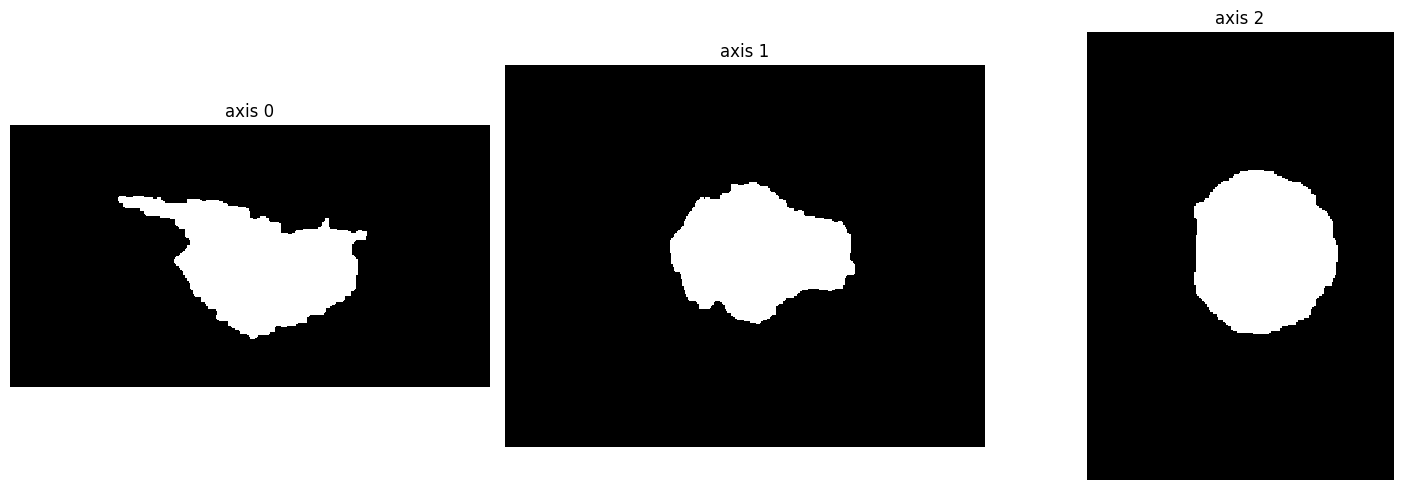

(<Figure size 1500x500 with 3 Axes>,
 [array([<AxesSubplot:title={'center':'axis 0'}>,
         <AxesSubplot:title={'center':'axis 1'}>,
         <AxesSubplot:title={'center':'axis 2'}>], dtype=object)])

In [26]:
from scipy.ndimage import distance_transform_edt
import scipy.ndimage as ndi

folder_path = "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/template/"
geom_data = sf.load_volume(os.path.join(folder_path, 'anat.nii.gz')).geom
pig_anat = sf.load_volume(os.path.join(folder_path, 'anat.nii.gz')).data#.reshape([param_3d.img_size_192,]*3).data
 #sf.load_volume(os.path.join(folder_path, 'anat_brain.nii.gz')).reshape([param_3d.img_size_192,]*3).data
pig_brain_mask = sf.load_volume(os.path.join(folder_path, 'anat_brain_mask.nii.gz')).data#.reshape([param_3d.img_size_192,]*3).data
# geom_data=sf.load_volume(os.path.join(folder_path, 'anat_brain_mask.nii.gz')).reshape([param_3d.img_size_192,]*3).geom

# Step 1: Fill Holes Inside the Mask
pig_brain_mask_filled = ndi.binary_fill_holes(pig_brain_mask)

from scipy.ndimage import binary_closing, binary_opening

# Apply morphological closing (fills small holes)
closed_mask = binary_closing(pig_brain_mask_filled, structure=np.ones((3,3,3)))

# Apply morphological opening (removes small protrusions)
pig_brain_mask = binary_opening(closed_mask, structure=np.ones((3,3,3)))


pig_brain = pig_anat * (pig_brain_mask == 1)
ne.plot.volume3D(pig_anat)
ne.plot.volume3D(pig_brain)
ne.plot.volume3D(pig_brain_mask)

In [59]:
# nib.save(nib.Nifti1Image(pig_anat.astype(np.int32), np.array(geom_data.vox2world)),os.path.join(folder_path, 'anat.nii.gz'))
nib.save(nib.Nifti1Image(pig_brain.astype(np.int32), np.eye(4)),os.path.join(folder_path, 'anat_brain.nii.gz'))
# nib.save(nib.Nifti1Image(pig_brain_mask.astype(np.int32), np.array(geom_data.vox2world)),os.path.join(folder_path, 'anat_brain_mask.nii.gz'))

In [21]:
np.array(geom_data.vox2world)

array([[-5.39772749e-01,  0.00000000e+00, -2.64326712e-12,
         7.43575211e+01],
       [ 0.00000000e+00, -5.39999962e-01,  0.00000000e+00,
         6.77581120e+00],
       [-2.64326712e-12,  0.00000000e+00,  5.39772749e-01,
        -9.02229462e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [50]:
pig_anat.shape

(192, 192, 192)

[ 0  1  2  3  4  5  6  7  8  9 10]


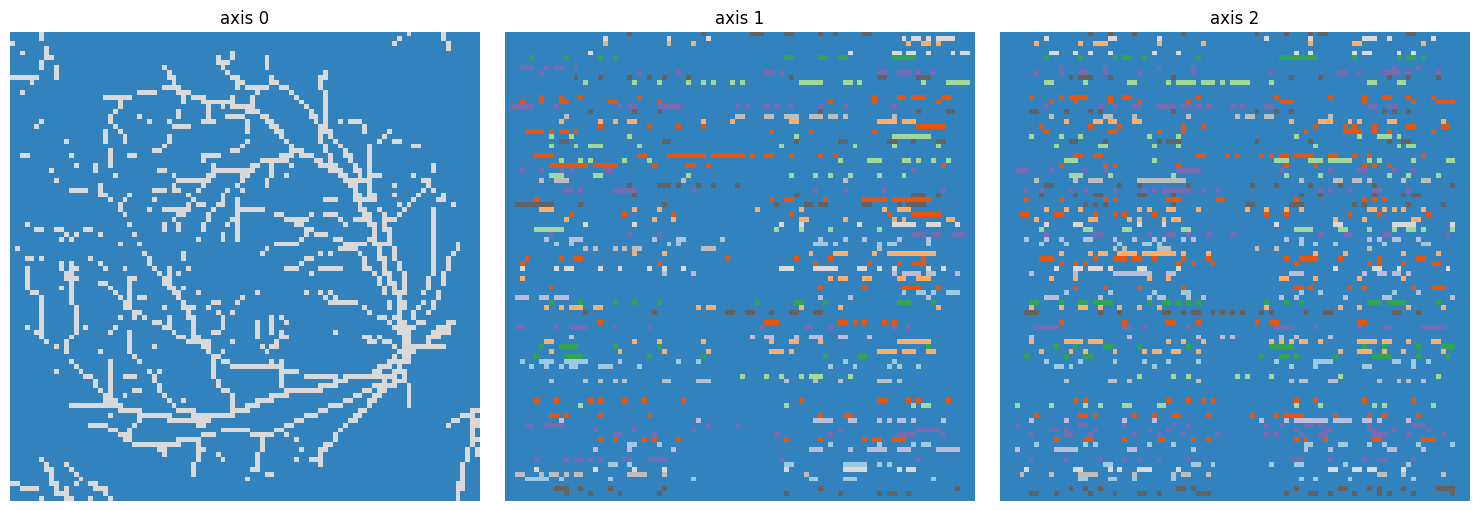

In [14]:
import tensorflow as tf
import numpy as np
from scipy.ndimage import gaussian_filter
from scipy.interpolate import splprep, splev
import cv2

import os
import random
import tensorflow as tf
import numpy as np
import cv2
from scipy.ndimage import binary_dilation

def load_retina_vessels_with_volume(folder_path, shape=(96, 96, 96), max_images=100):
    """
    Load 2D vessel PNGs, resize to fit into 3D volume, and stack them randomly without thickness or dilation.
    """
    files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.png')]
    selected = random.sample(files, min(max_images, len(files)))

    volume = np.zeros(shape, dtype=np.uint8)
    depth = shape[0]

    used_slices = set()

    for i, path in enumerate(selected):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img_resized = cv2.resize(img, (shape[1], shape[2]))
        binary_mask = (img_resized > 40).astype(np.uint8)

        label = random.randint(1, 10) 

        # Pick a random unused slice
        possible_slices = list(set(range(depth)) - used_slices)
        if not possible_slices:
            break  # no more slices available
        z_idx = random.choice(possible_slices)
        used_slices.add(z_idx)

        # Apply label only where volume is 0
        vessel_slice = binary_mask * label
        volume[z_idx] = np.where(volume[z_idx] == 0, vessel_slice, volume[z_idx])

    return tf.convert_to_tensor(volume, dtype=tf.int32)
    
# def generate_vessel_tensorflow(
#     shape=(256, 256, 256),
#     num_streamlines=1000,
#     max_length=180,
#     thickness_range=(1, 2),
#     label_range=(1, 10),
#     smooth_sigma=0.0,
#     seed=42
# ):
#     np.random.seed(seed)
#     volume = np.zeros(shape, dtype=np.int32)

#     for _ in range(num_streamlines):
#         start = np.random.randint(0, shape[0], size=3)
#         num_ctrl_pts = np.random.randint(5, 10)
#         ctrl_pts = np.zeros((3, num_ctrl_pts))

#         for i in range(3):
#             noise = np.cumsum(np.random.randn(num_ctrl_pts) * 5)
#             ctrl_pts[i] = np.clip(start[i] + noise, 0, shape[i] - 1)

#         try:
#             tck, _ = splprep(ctrl_pts, s=0)
#             u = np.linspace(0, 1, max_length)
#             x, y, z = splev(u, tck)
#         except:
#             continue

#         label = np.random.randint(label_range[0], label_range[1] + 1)

#         for xi, yi, zi in zip(x, y, z):
#             xi, yi, zi = int(xi), int(yi), int(zi)
#             if 0 <= xi < shape[0] and 0 <= yi < shape[1] and 0 <= zi < shape[2]:
#                 r = np.random.randint(*thickness_range)
#                 xs = slice(max(0, xi - r), min(shape[0], xi + r + 1))
#                 ys = slice(max(0, yi - r), min(shape[1], yi + r + 1))
#                 zs = slice(max(0, zi - r), min(shape[2], zi + r + 1))
#                 volume[xs, ys, zs] = label

#     if smooth_sigma > 0:
#         blurred = gaussian_filter(volume.astype(np.float32), sigma=smooth_sigma)
#         volume = (blurred > 0.2).astype(np.uint8)

#     return volume


# def combine_shapes_and_vessels_tf(shape=(96, 96, 96), num_vessel_labels=10, seed=42):
#     # Step 1: Draw shapes (organs)
#     shape_map = draw_shapes(shape=shape, num_label=num_vessel_labels)
#     np.unique(shape_map)
#     shape_map = tf.squeeze(tf.cast(shape_map, tf.int32))
#     print(np.unique(shape_map))

#     # Step 2: Generate vessel-like streamlines
#     vessel_map = generate_vessel_tensorflow(shape=shape, num_streamlines=200, seed=seed)

#     # Step 3: Convert vessel map to int32 and offset labels to avoid overlap
#     vessel_map = tf.cast(vessel_map, tf.int32)
#     max_shape_label = tf.reduce_max(shape_map)
#     vessel_map = tf.where(vessel_map > 0, vessel_map + max_shape_label, 0)

#     print("##",np.unique(shape_map),np.unique(vessel_map))

#     # Step 4: Combine them
#     # combined = tf.where(shape_map > 0, shape_map, vessel_map)
#     combined = tf.where(vessel_map > 0, vessel_map , shape_map)

#     return combined

# def load_retina_vessels_with_volume(folder_path, shape=(96, 96, 96), max_images=10):
#     """
#     Load vessel PNGs, resize them to fit 3D, add thickness, and return a vessel volume.
#     """
#     files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.png')]
#     selected = random.sample(files, min(max_images, len(files)))

#     volume = np.zeros(shape, dtype=np.uint8)
#     depth = shape[0]

#     for i, path in enumerate(selected):
#         img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
#         img_resized = cv2.resize(img, (shape[1], shape[2]))
#         binary_mask = (img_resized > 40).astype(np.uint8)

#         # Add 3D thickness using binary dilation in (depth, height, width)
#         slice_thickness = random.randint(1, 3)
#         label = random.randint(1, 10)
#         for z_offset in range(slice_thickness):
#             z_idx = min(depth - 1, i + z_offset)
#             vessel_slice = binary_dilation(binary_mask, iterations=1).astype(np.uint8)
#             vessel_slice = vessel_slice * label
#             volume[z_idx] = np.where(volume[z_idx] == 0, vessel_slice, volume[z_idx])  # Do not overwrite

#     return tf.convert_to_tensor(volume, dtype=tf.int32)
    


# def load_retina_vessels_with_volume(folder_path, shape=(96, 96, 96), max_images=100):
#     """
#     Load 2D vessel PNGs, resize to fit into 3D volume, and stack them randomly without thickness or dilation.
#     """
#     files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.png')]
#     selected = random.sample(files, min(max_images, len(files)))

#     volume = np.zeros(shape, dtype=np.uint8)
#     depth = shape[0]

#     used_slices = set()

#     for i, path in enumerate(selected):
#         img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
#         img_resized = cv2.resize(img, (shape[1], shape[2]))
#         binary_mask = (img_resized > 40).astype(np.uint8)

#         label = i + 1

#         # Pick a random unused slice
#         possible_slices = list(set(range(depth)) - used_slices)
#         if not possible_slices:
#             break  # no more slices available
#         z_idx = random.choice(possible_slices)
#         used_slices.add(z_idx)

#         # Apply label only where volume is 0
#         vessel_slice = binary_mask * label
#         volume[z_idx] = np.where(volume[z_idx] == 0, vessel_slice, volume[z_idx])

#     return tf.convert_to_tensor(volume, dtype=tf.int32)



combined_map = load_retina_vessels_with_volume("retina_blood_vessles", max_images=500,
    shape=(96, 96, 96))

print(np.unique(combined_map))
ne.plot.volume3D(combined_map.numpy(), cmaps=['tab20c'])
nib.save(nib.Nifti1Image(combined_map.numpy().astype(np.int32), np.eye(4)), os.path.join("synth_data", 'streamline.nii.gz'))


In [15]:
def shift_non_zero_back_elements(bg, shift_value):
    non_zero_mask = tf.not_equal(bg, 0)
    shifted_non_zero_elements = tf.where(non_zero_mask, bg -shift_value, bg)
    return shifted_non_zero_elements

    
with open("params_gmm_seg_96.json", "r") as json_file:
    config = json.load(json_file)
# pig_brain_map = [predicted_anat_labels]
gen=generator_brain_window_Net(pig_brain_map,param_3d.img_size_96)

num_forground_classes = 6
model_pig_config = config["pig_48"]
model_shapes_config = config["shapes"]
model_veins_config = config["veins"]
model_shapes_config["labels_in"] = [0] + list(range(7, 17))
model_veins_config["labels_in"] = [0] + list(range(7, 17))

model_pig_config["in_shape"]=[ param_3d.img_size_96, param_3d.img_size_96, param_3d.img_size_96]



model_shapes_config["in_shape"]=[ param_3d.img_size_96, param_3d.img_size_96, param_3d.img_size_96]
model_veins_config["in_shape"]=[ param_3d.img_size_96, param_3d.img_size_96, param_3d.img_size_96]


model3_config = config["labels_to_image_model_48"]
all_possible_labels = list(range(0,17))  # or use np.unique(pig_seg) if available

model3_config["labels_in"] = all_possible_labels

model3_config["labels_out"] = {int(key): value for key, value in model3_config["labels_out"].items()}

model_shapes_config["labels_out"] = {
    int(key): int(key) if int(key) in model_shapes_config["labels_in"] else 0
    for key in model3_config["labels_out"].keys()
}

model_veins_config["labels_out"] = {
    int(key): int(key) if int(key) in model_veins_config["labels_in"] else 0
    for key in model3_config["labels_out"].keys()
}


model_shapes_config["aff_shift"]=0
model_shapes_config["aff_shear"]=0
model_shapes_config["aff_scale"]=0


model_pig_config["aff_rotate"]=0
model_pig_config["aff_scale"]=0

model_pig_config["labels_out"] = {
    int(key): int(key) if int(key) in model_pig_config["labels_in"] else 0
    for key in model3_config["labels_out"].keys()
}
model3_config["in_shape"]=[ param_3d.img_size_96 , param_3d.img_size_96, param_3d.img_size_96]
model_pig = create_model(model_pig_config)
model_shapes = create_model(model_shapes_config)
model_veins = create_model(model_veins_config)

shapes = draw_shapes_easy(shape = ( param_3d.img_size_96,)*3)   

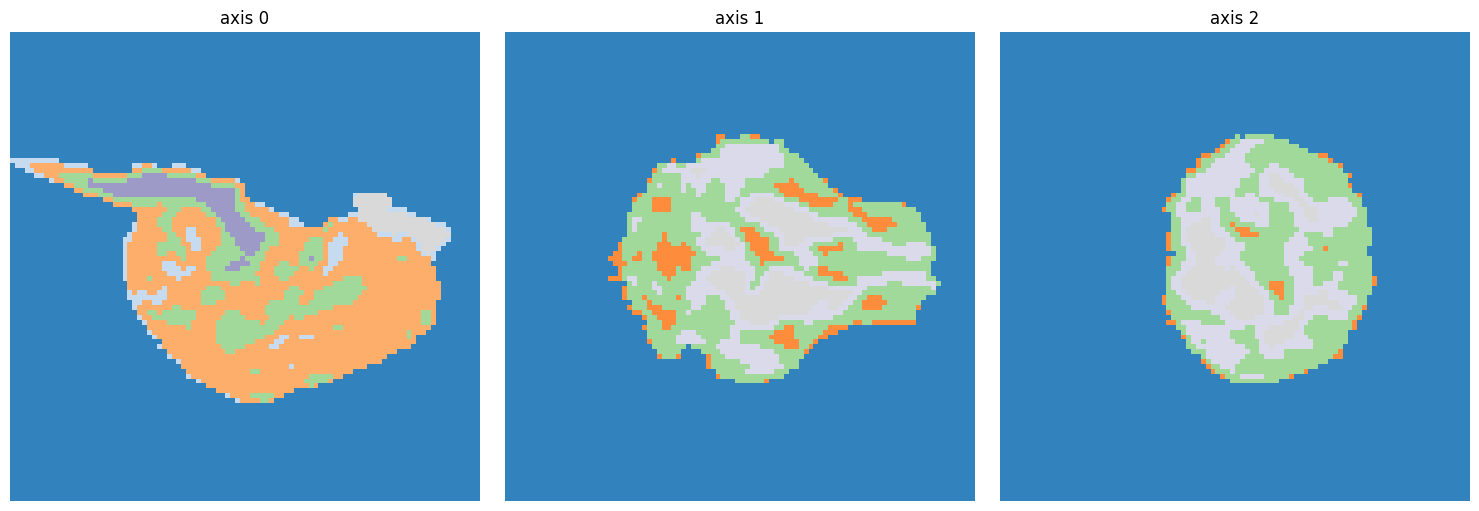

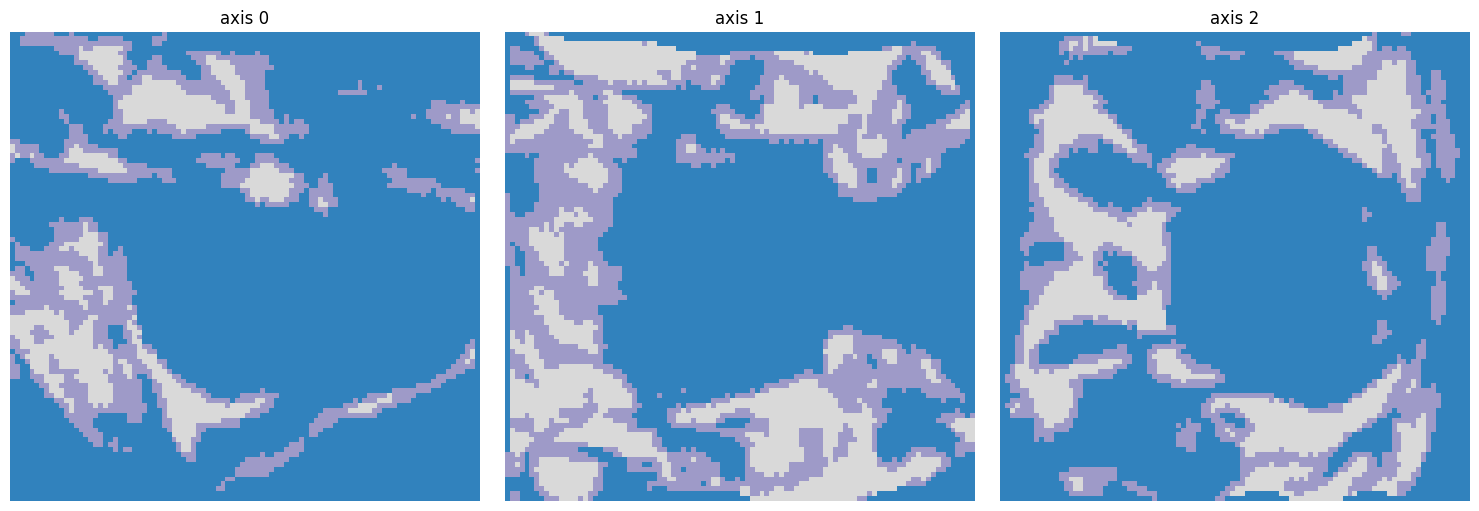

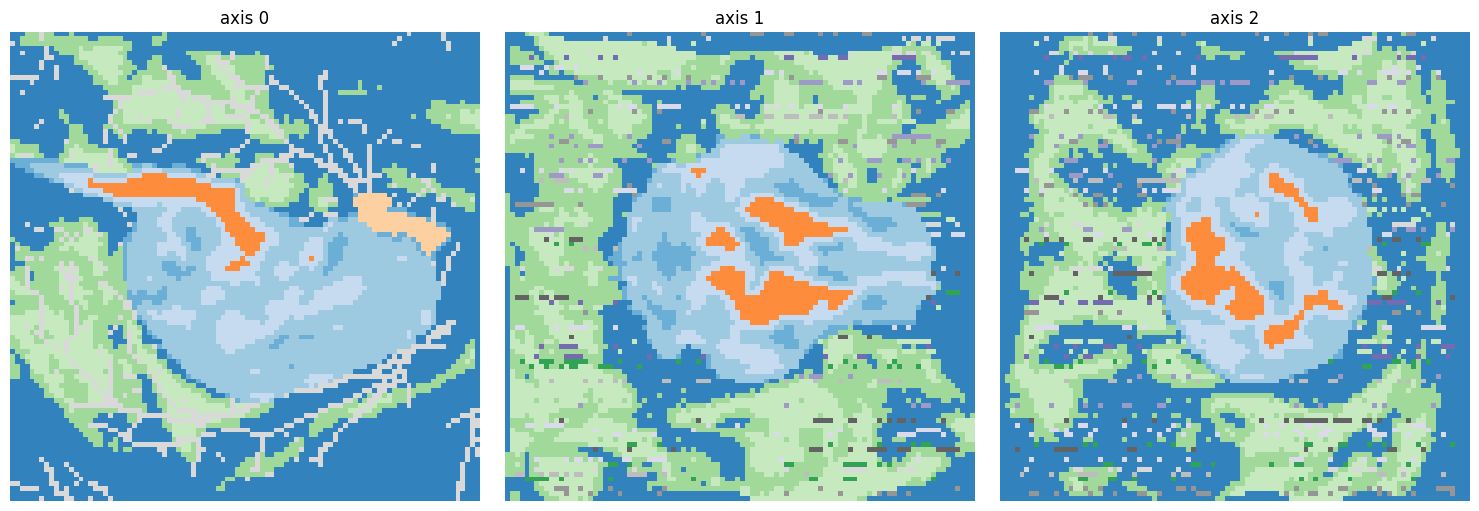

[0 2 3]


In [22]:
    
def mask_bg_near_fg(fg, bg, dilation_iter=8):
    d_iter = tf.random.uniform([], minval=1, maxval=dilation_iter + 1, dtype=tf.int32)
    k = 2 * d_iter + 1
    fg_mask = tf.cast(fg > 0, tf.float32)
    fg_mask = tf.reshape(fg_mask, [1, *fg_mask.shape, 1])
    fg_mask = tf.nn.max_pool3d(fg_mask, ksize=[1, k, k, k, 1], strides=[1, 1, 1, 1, 1], padding='SAME')
    fg_mask = tf.squeeze(fg_mask > 0)

    bg_masked = tf.where(fg_mask, bg, tf.zeros_like(bg[0, ..., 0]))
    result = tf.where(fg > 0, fg, bg_masked)
    return result
    
fragment = next(gen)
_, fg = model_pig(fragment)
_, bg = model_shapes(fragment)

bg = shift_non_zero_back_elements(bg[0,...,0],6)

# _, cm = model_veins(combined_map[None,...,None])
# cm = cm[0,...,0]
final_shapes = tf.where(combined_map == 0, bg, combined_map)
final_shapes = shift_non_zero_elements(final_shapes,6)


# result = fg[0,...,0] + final_shapes * tf.cast(fg[0,...,0] == 0,tf.int32)

result = mask_bg_near_fg(fg[0,...,0], final_shapes , dilation_iter=55)

# result = fg[0,...,0] + bg * tf.cast(fg[0,...,0] == 0,tf.int32)
ne.plot.volume3D(fg[0,...,0].numpy(), cmaps=['tab20c'])
# ne.plot.volume3D(c.numpy(), cmaps=['tab20c'])

ne.plot.volume3D(bg.numpy(), cmaps=['tab20c'])
ne.plot.volume3D(result.numpy(), cmaps=['tab20c'])

print(np.unique(bg))
# result = result[None,...,None]


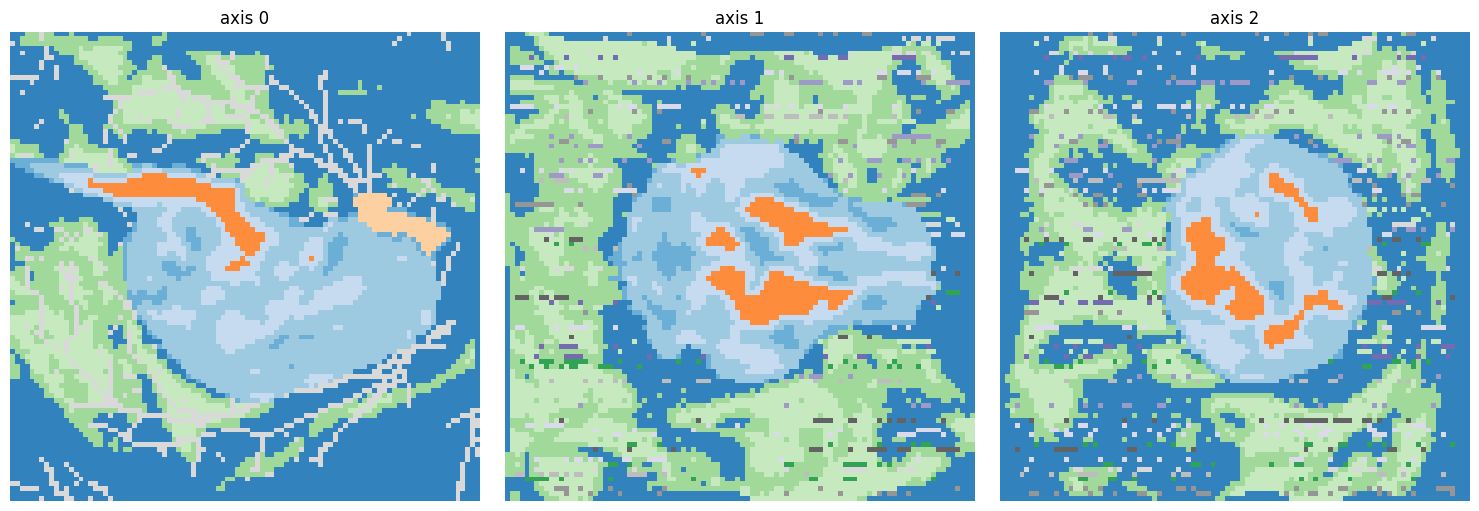

In [23]:
# final_shapes = tf.where(combined_map == 0, bg, combined_map)
# final_shapes = shift_non_zero_elements(final_shapes,6)

# result = fg[0,...,0] + final_shapes * tf.cast(fg[0,...,0] == 0,tf.int32)

ne.plot.volume3D(result, cmaps=['tab20c'])
nib.save(nib.Nifti1Image(result.numpy().astype(np.int32), np.eye(4)), os.path.join("synth_data", 'streamline.nii.gz'))


(1, 96, 96, 96, 1)
(96, 96, 96) 83116


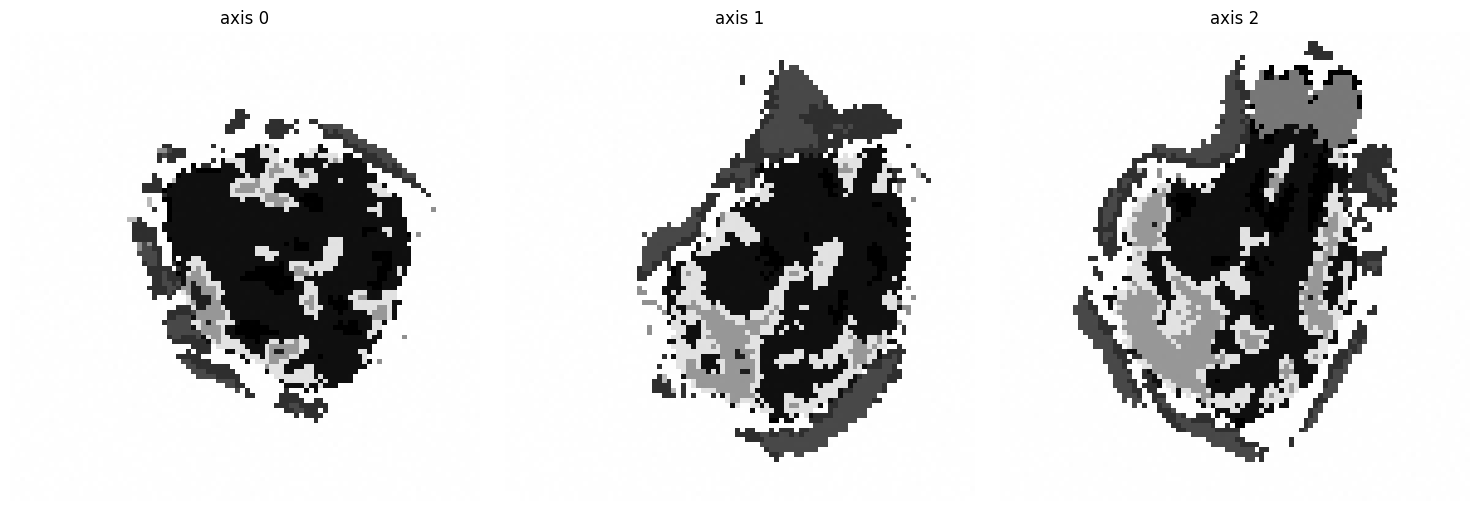

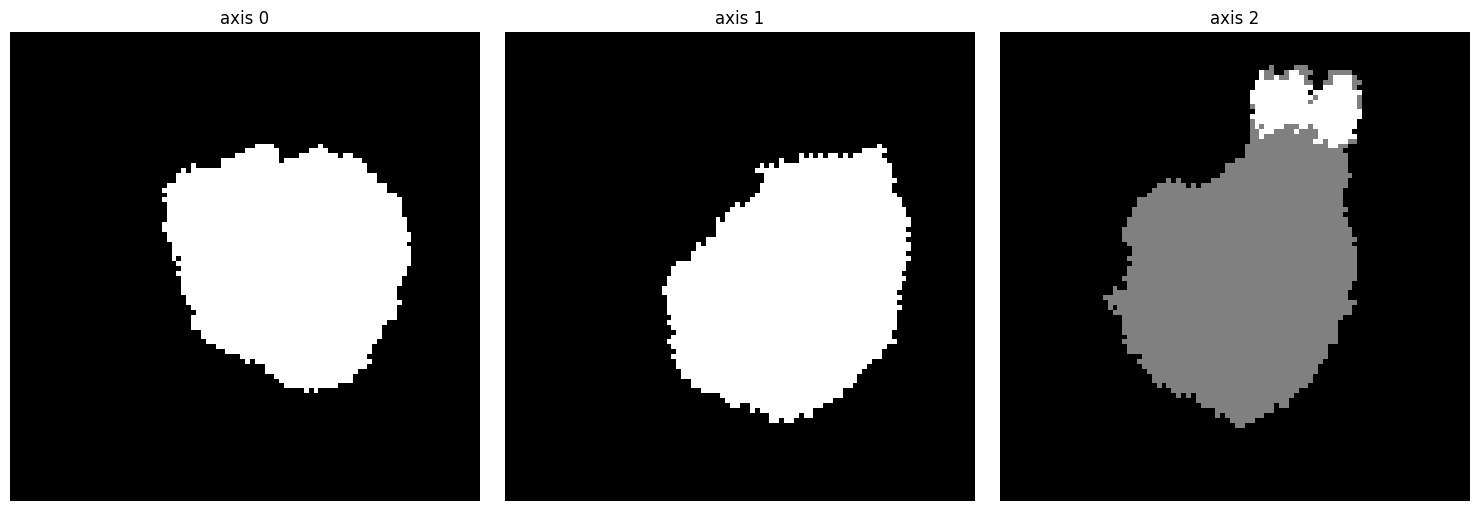

(1, 96, 96, 96, 1)
(96, 96, 96) 75176


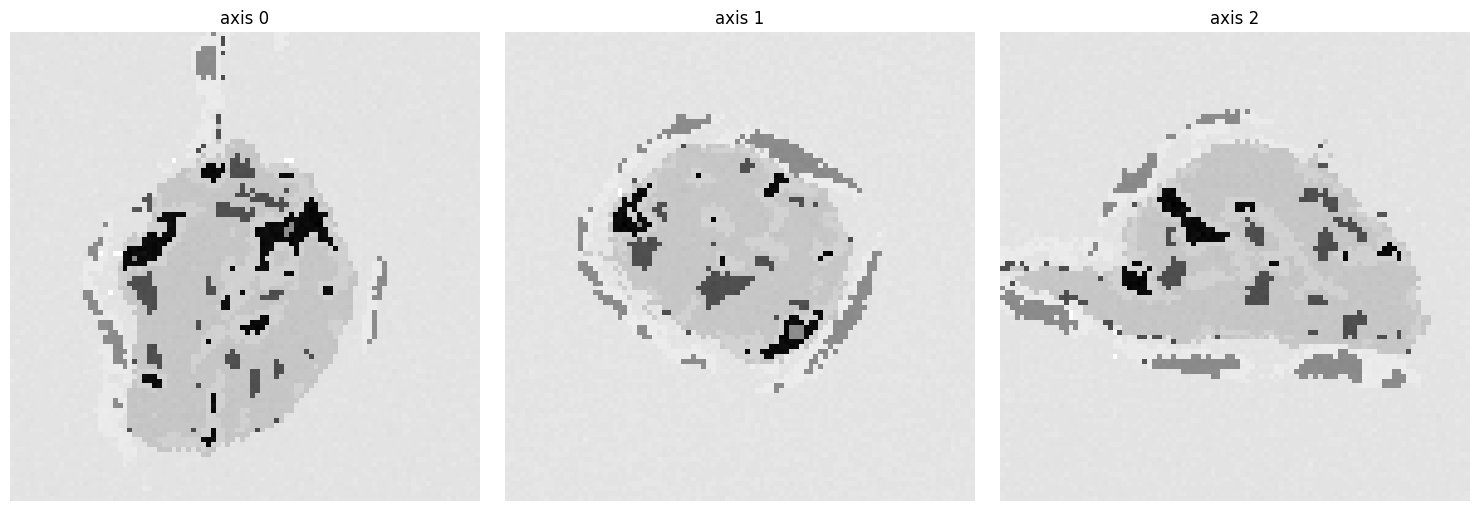

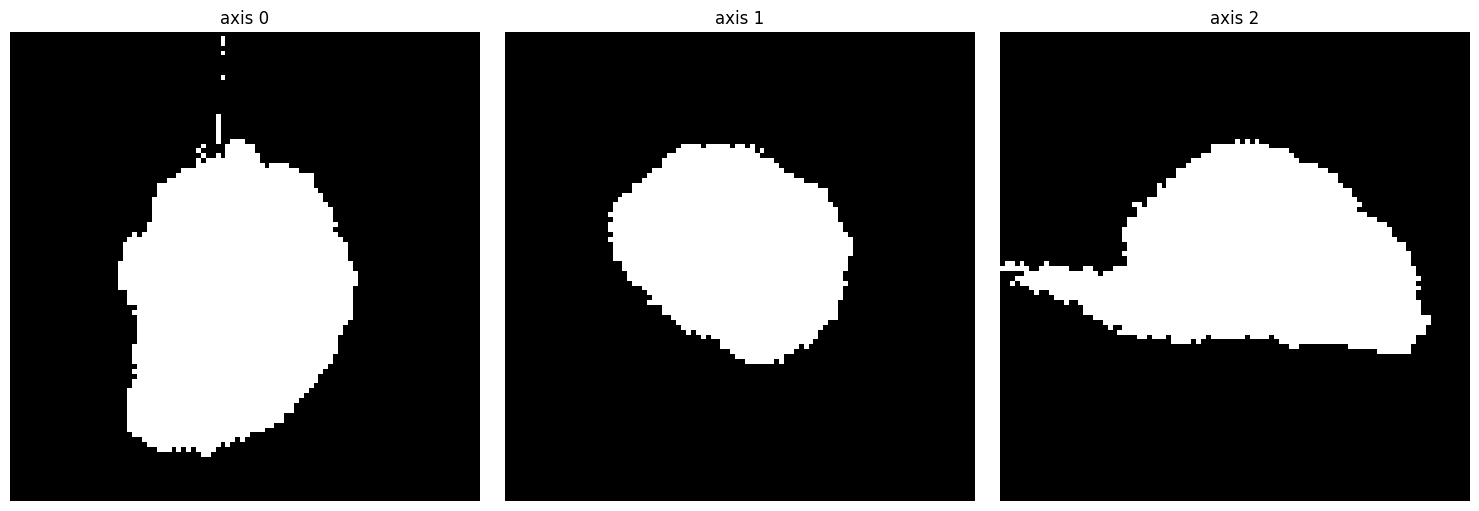

(1, 96, 96, 96, 1)
(96, 96, 96) 79599


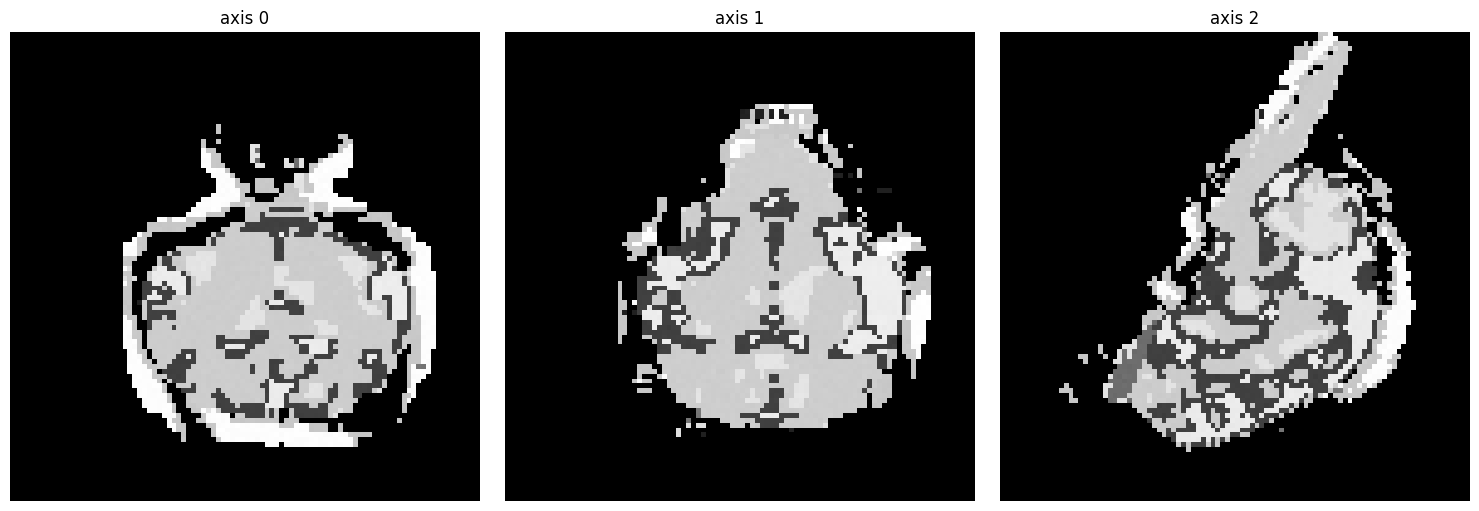

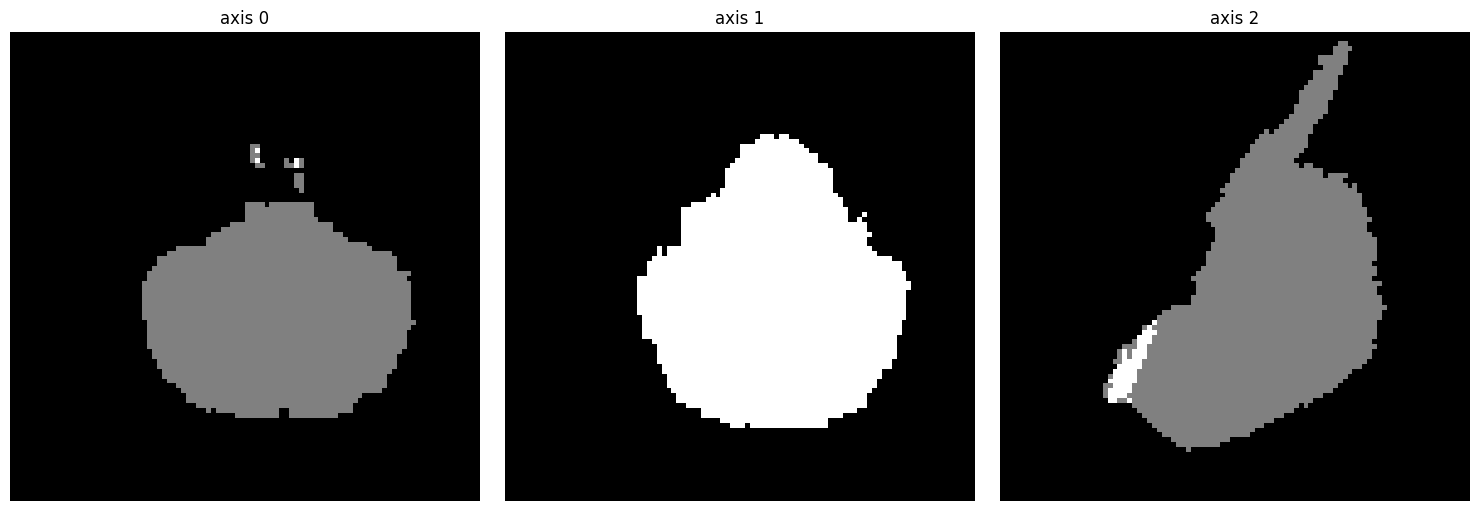

(1, 96, 96, 96, 1)
(96, 96, 96) 82091


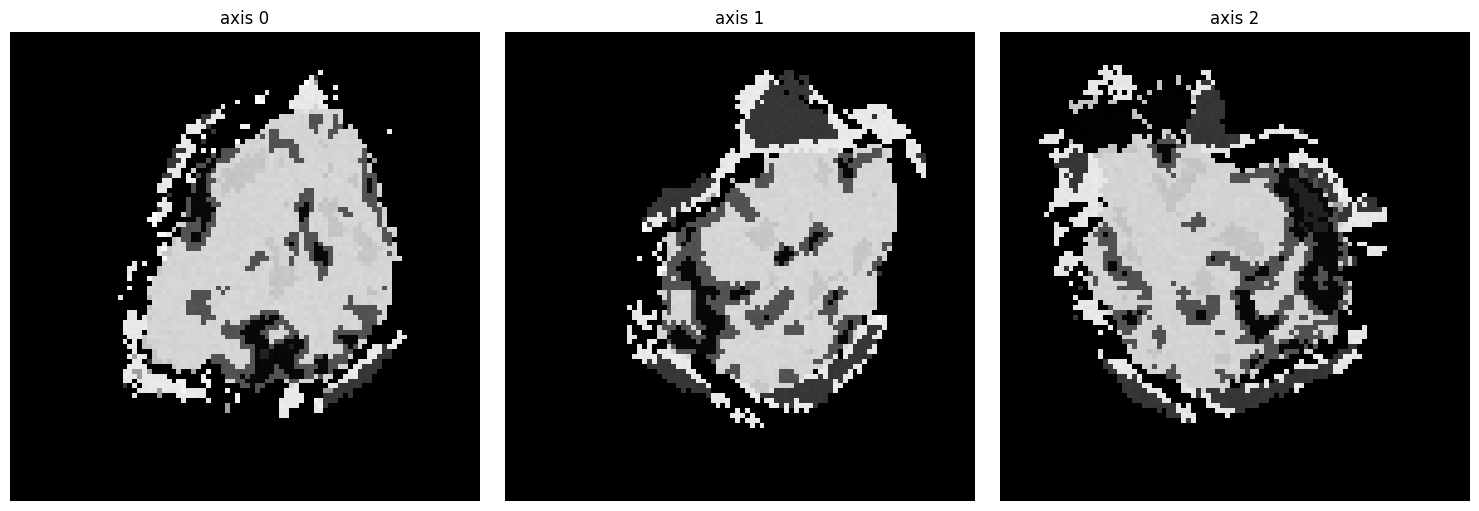

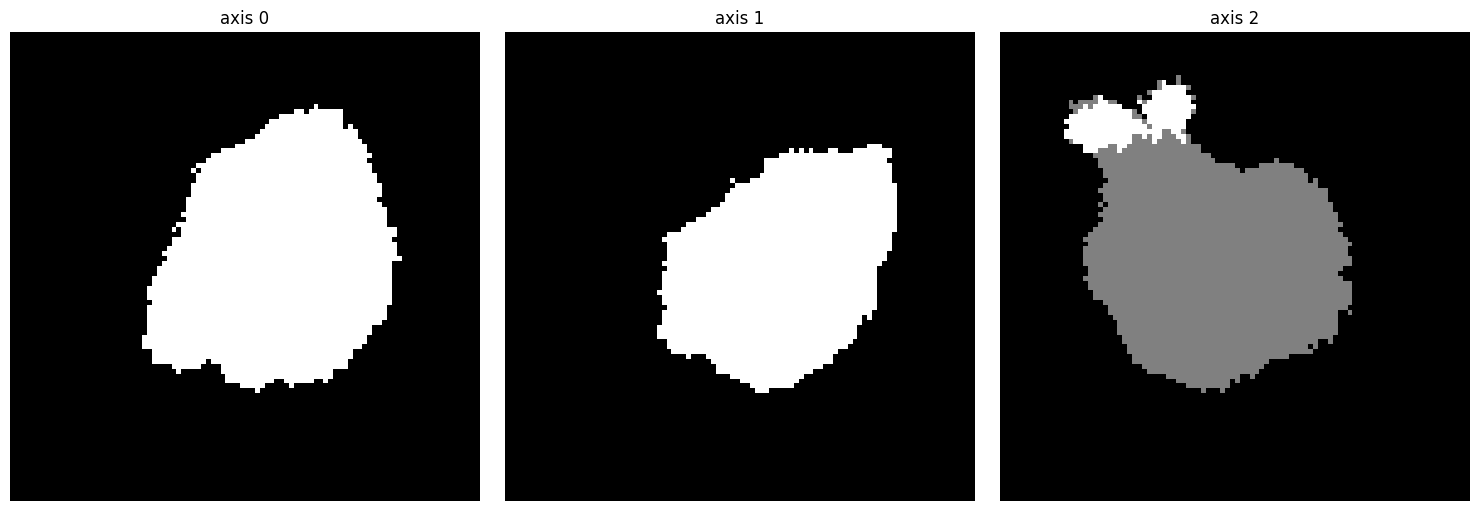

(1, 96, 96, 96, 1)
(96, 96, 96) 83361


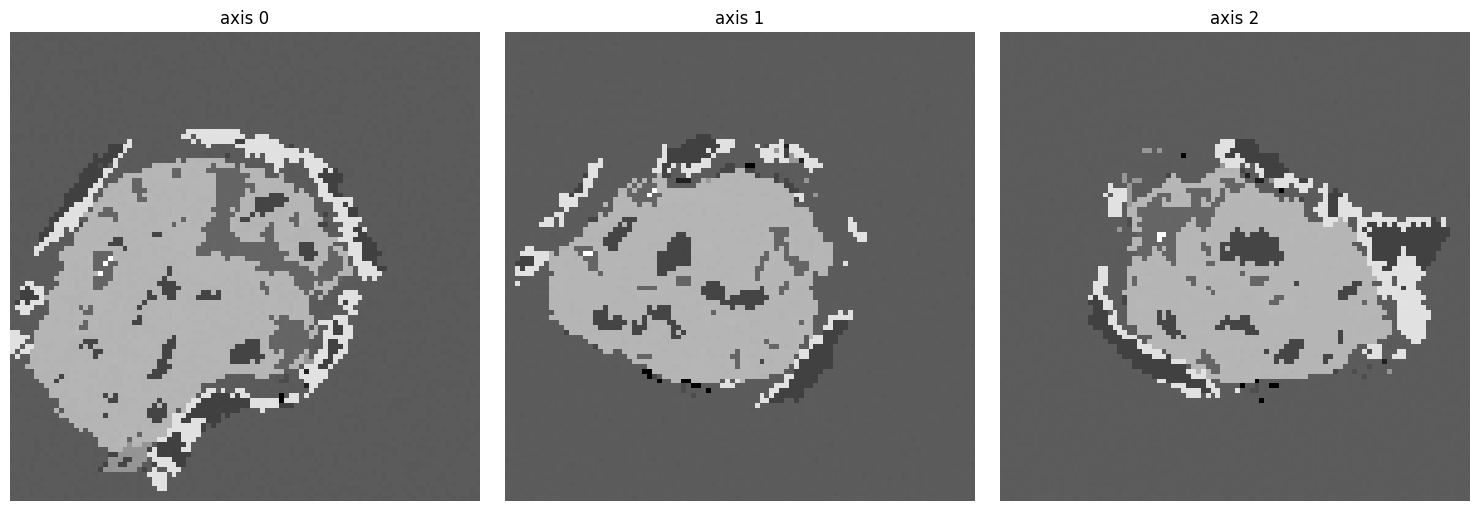

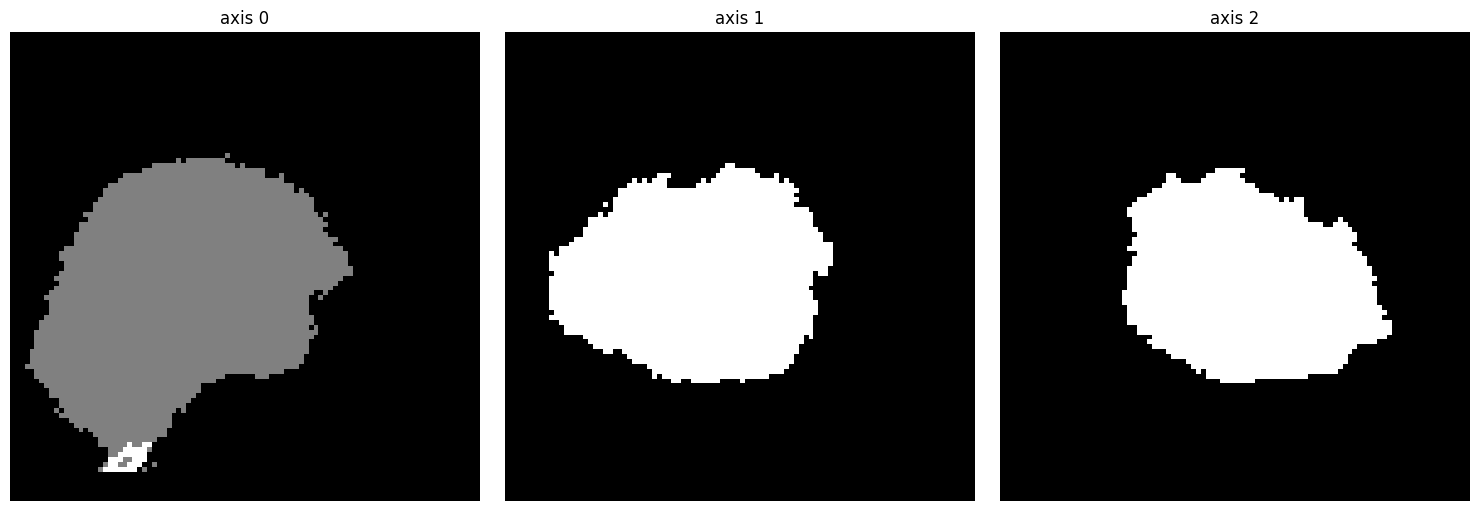

In [26]:
for i in range(5):
    labels_to_image_model = create_model(model3_config)
    generated_img, y = labels_to_image_model(result[None,...,None])
    
    print(generated_img.shape)
    z=np.argmax(y,axis=-1)
    ms = np.mean(np.column_stack(np.nonzero(z[0])), axis=0).astype(int)
    mask = np.argmax(y,axis=-1)[0]
    print(mask.shape,np.sum(mask))
    ne.plot.volume3D(generated_img,slice_nos=ms);
    ne.plot.volume3D(mask,slice_nos=ms);
    nib.save(nib.Nifti1Image(generated_img[0,...,0].numpy(), np.eye(4)),os.path.join("synth_data", str(i)+'_img.nii.gz'))
    nib.save(nib.Nifti1Image(mask.astype(np.int32), np.eye(4)),os.path.join("synth_data", str(i)+'_mask.nii.gz'))

In [17]:
from sklearn.mixture import GaussianMixture
from scipy.ndimage import gaussian_filter

from utils import *
from help import *
k1=6
k2=6

folders_path = [
        "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/template/",
               ]

scaling_factor=0.7

predicted_anat_labels=[]
for folder_path in folders_path:

    from scipy.ndimage import zoom
    
    # geom_data = sf.load_volume(os.path.join(folder_path, 'anat.nii.gz')).geom
    # pig_anat = sf.load_volume(os.path.join(folder_path, 'anat.nii.gz')).reshape([param_3d.img_size_256,]*3).data
    # pig_brain_mask = sf.load_volume(os.path.join(folder_path, 'anat_brain_mask.nii.gz')).reshape([param_3d.img_size_256,]*3).data
    def load_volume_file(folder_path, file_name):
        # Try both extensions in a loop
        for ext in ['.nii.gz', '.nii']:
            file_path = os.path.join(folder_path, file_name + ext)
            print(f"Checking: {repr(file_path)}")  # Debug print to see which path is being checked
            if os.path.exists(file_path):
                return sf.load_volume(file_path).reshape([param_3d.img_size_256,]*3).data
    
        # If neither file is found
        raise FileNotFoundError(f"{file_name} file not found in {folder_path}.")

        
    # geom_data = sf.load_volume(os.path.join(folder_path, 'anat.nii.gz')).geom
    pig_anat = load_volume_file(folder_path, 'anat')
    geom_data = pig_anat  # Assuming geom_data is the same as pig_anat.data
    pig_brain_mask = load_volume_file(folder_path, 'anat_brain_olfactory_mask')
    pig_brain_mask = (pig_brain_mask > 0).astype(np.uint8)
    

    sigma = 0.8  # Adjust sigma for desired smoothing effect
    pig_anat = gaussian_filter(pig_anat, sigma=sigma)
    
    pig_brain_mask = ndi.binary_fill_holes(pig_brain_mask)
    pig_brain = pig_anat * (pig_brain_mask == 1)
    
    pig_anat = sf.Volume(zoom(pig_anat, scaling_factor, order=1)).reshape((256,)*3).data
    pig_brain = sf.Volume(zoom(pig_brain, scaling_factor, order=1)).reshape((256,)*3).data
    pig_brain_mask = sf.Volume(zoom(pig_brain_mask, scaling_factor, order=1)).reshape((256,)*3).data
    pig_brain_mask = ndi.binary_fill_holes(pig_brain_mask)

    pig_skull = np.copy(pig_anat)
    pig_skull[pig_brain_mask == 1] = 0
    # sigma = 1  # Adjust sigma for desired smoothing effect
    smoothed_anat = gaussian_filter(pig_anat, sigma=sigma)
    brain_data = pig_brain.flatten().reshape(-1, 1)
    non_brain_data = pig_skull.flatten().reshape(-1, 1)

    def make_smooth(label_map,s=1):
        smoothed_labels = gaussian_filter(label_map.astype(float), sigma=s)
        return np.round(smoothed_labels).astype(int)
        
    # Apply GMM for brain regions (assumes 29 brain regions to be classified)
    gmm_brain = GaussianMixture(n_components=k1, random_state=np.random.randint(0, 10000))
    gmm_brain.fit(brain_data)  # Fit GMM on the brain data
    
    # Apply GMM for non-brain regions (background and other tissues)
    gmm_non_brain = GaussianMixture(n_components=k2, random_state=42)  # 0 for background, 30-40 for other tissues
    gmm_non_brain.fit(non_brain_data)  # Fit GMM on the non-brain data
    
    # Predict the components (labels) for brain and non-brain regions
    predicted_brain_labels = gmm_brain.predict(brain_data)

    if k1==0:
        pig_seg = sf.load_volume(os.path.join(folder_path, 'fast_segmentation_seg.nii.gz')).resize(1).reshape([param_3d.img_size_256,]*3).data
        pig_seg = sf.Volume(zoom(pig_seg, scaling_factor, order=1)).reshape((256,)*3)
        predicted_brain_labels = pig_seg
        
    predicted_non_brain_labels = gmm_non_brain.predict(non_brain_data)
    
    predicted_brain_labels = make_smooth(predicted_brain_labels,sigma)
    predicted_non_brain_labels = make_smooth(predicted_non_brain_labels,sigma)
    

    predicted_brain_labels = predicted_brain_labels.reshape((256,256,256))
    predicted_non_brain_labels = predicted_non_brain_labels.reshape((256,256,256))


        

    predicted_non_brain_labels[pig_brain_mask == 1] = 0
    predicted_non_brain_labels = shift_non_zero_elements(predicted_non_brain_labels,6)
    predicted_anat_label = np.where(predicted_brain_labels > 0, predicted_brain_labels, predicted_non_brain_labels)

    zoomed_predicted_anat_labels = sf.Volume(predicted_anat_label).reshape([128,]*3)

Checking: '/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/template/anat.nii.gz'
[DEBUG] NiftiArrayIO.load(): no header extensions found!
Checking: '/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/template/anat_brain_olfactory_mask.nii.gz'
[DEBUG] NiftiArrayIO.load(): no header extensions found!


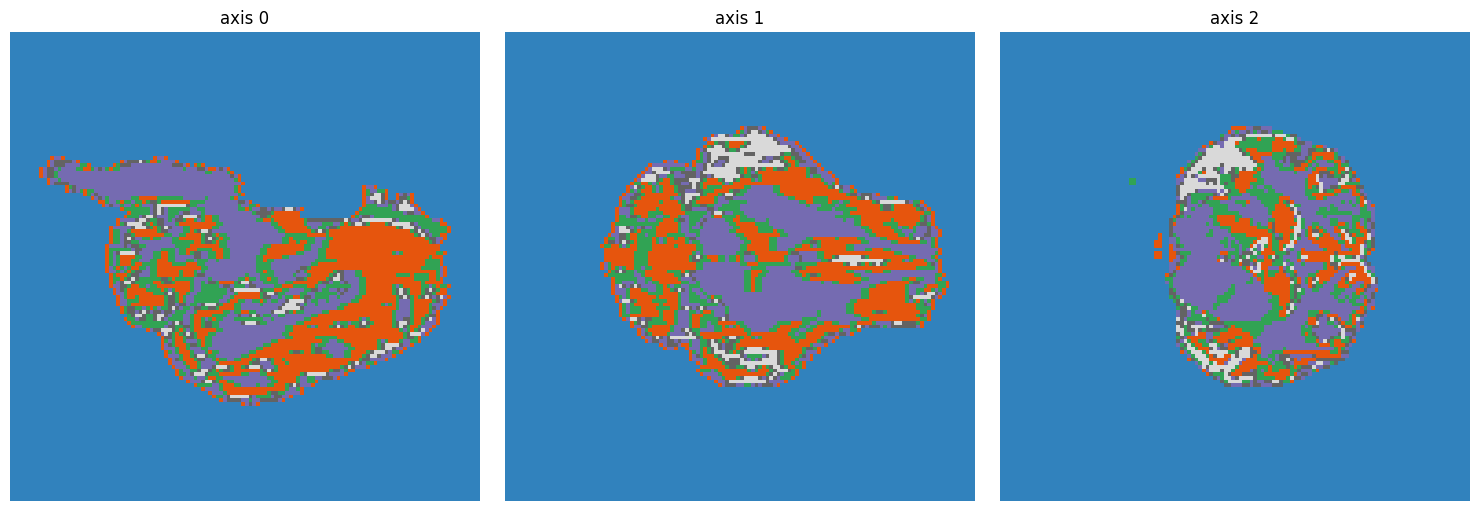

In [18]:
masked_label_map = np.where((zoomed_predicted_anat_labels.data >= 1) & 
                            (zoomed_predicted_anat_labels.data <= 6),
                            zoomed_predicted_anat_labels.data,
                            0)
ne.plot.volume3D(sf.Volume(masked_label_map), cmaps=['tab20c'])
nib.save(nib.Nifti1Image(masked_label_map.astype(np.int32), np.eye(4)), os.path.join("synth_data", 'gmm.nii.gz'))

In [21]:
from scipy.ndimage import zoom, gaussian_filter
import numpy as np
import os
from utils import *
from help import *
from hmrf_em import normalize, kmeans_init, run_hmrf_em
import scipy.ndimage as ndi

from scipy.ndimage import gaussian_filter

def soften_labels_via_gaussian(label_map, sigma=1):
    n_classes = int(label_map.max()) + 1
    smoothed_probs = np.zeros((n_classes,) + label_map.shape)

    for c in range(n_classes):
        class_mask = (label_map == c).astype(float)
        smoothed_probs[c] = gaussian_filter(class_mask, sigma=sigma)

    softened = np.argmax(smoothed_probs, axis=0)
    return softened


# HMRF parameters
n_classes = 6
beta = 0.5
max_iter = 15
sigma = 0.6  # smoothing before clustering

folders_path = [
    "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/template/",
]

scaling_factor = 0.7
predicted_anat_labels = []

def load_volume_file(folder_path, file_name):
    for ext in ['.nii.gz', '.nii']:
        file_path = os.path.join(folder_path, file_name + ext)
        print(f"Checking: {repr(file_path)}")
        if os.path.exists(file_path):
            return sf.load_volume(file_path).reshape([param_3d.img_size_256,]*3).data
    raise FileNotFoundError(f"{file_name} not found in {folder_path}")

for folder_path in folders_path:
    # Load anatomical image and mask
    pig_anat = load_volume_file(folder_path, 'anat')
    pig_brain_mask = load_volume_file(folder_path, 'anat_brain_olfactory_mask')
    pig_brain_mask = (pig_brain_mask > 0).astype(np.uint8)

    # Smooth the image
    pig_anat = gaussian_filter(pig_anat, sigma=sigma)

    # Fill holes and apply mask
    pig_brain_mask = ndi.binary_fill_holes(pig_brain_mask)
    pig_brain = pig_anat * pig_brain_mask

    # Resize to standard resolution
    pig_anat = sf.Volume(zoom(pig_anat, scaling_factor, order=1)).reshape((256,)*3).data
    pig_brain = sf.Volume(zoom(pig_brain, scaling_factor, order=1)).reshape((256,)*3).data
    pig_brain_mask = sf.Volume(zoom(pig_brain_mask, scaling_factor, order=1)).reshape((256,)*3).data
    pig_brain_mask = ndi.binary_fill_holes(pig_brain_mask)

    # Normalize intensity inside brain region
    pig_brain = normalize(pig_brain.astype(np.float32))

    # KMeans initialization
    init_labels = kmeans_init(pig_brain, pig_brain_mask, n_classes=n_classes)

    # Run HMRF-EM
    print(f"Running HMRF on {folder_path} ...")
    final_segmentation = run_hmrf_em(
        image=pig_brain,
        mask=pig_brain_mask,
        init_labels=init_labels,
        n_classes=n_classes,
        beta=beta,
        max_iter=max_iter
    )

    # Resize output if needed
    predicted_anat_label = final_segmentation
    predicted_anat_label = fill_holes_per_class(predicted_anat_label)
    predicted_anat_label = soften_labels_via_gaussian(predicted_anat_label,sigma=0.8)
    zoomed_predicted_anat_labels = sf.Volume(predicted_anat_label).reshape([128]*3)
    
    predicted_anat_labels.append(zoomed_predicted_anat_labels)


Checking: '/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/template/anat.nii.gz'
[DEBUG] NiftiArrayIO.load(): no header extensions found!
Checking: '/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/template/anat_brain_olfactory_mask.nii.gz'
[DEBUG] NiftiArrayIO.load(): no header extensions found!
Running HMRF on /gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/template/ ...
[HMRF] Iteration 1/25
[HMRF] Iteration 2/25
[HMRF] Iteration 3/25
[HMRF] Iteration 4/25
[HMRF] Iteration 5/25
[HMRF] Iteration 6/25
[HMRF] Iteration 7/25
[HMRF] Iteration 8/25
[HMRF] Iteration 9/25
[HMRF] Iteration 10/25
[HMRF] Iteration 11/25
[HMRF] Iteration 12/25
[HMRF] Iteration 13/25
[HMRF] Iteration 14/25
[HMRF] Iteration 15/25
[HMRF] Iteration 16/25
[HMRF] Iteration 17/25
[HMRF] Iteration 18/25
[HMRF] Iteration 19/25
[HMRF] Iteration 20/25
[HMRF] Iteration 21/25
[HMRF] Iteration 22/25
[HMRF] Iteration 23/25
[HMRF] Iteration 24/25
[HMRF] Iteration 25/25


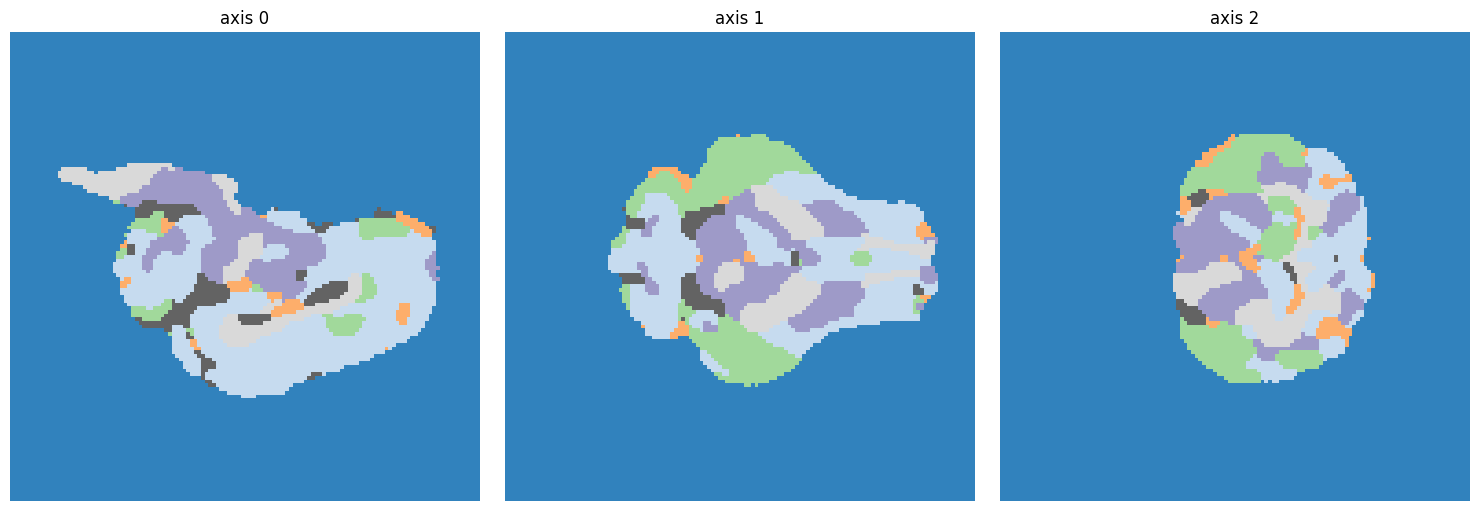

In [22]:
masked_label_map = np.where((zoomed_predicted_anat_labels.data >= 1) & 
                            (zoomed_predicted_anat_labels.data <= 6),
                            zoomed_predicted_anat_labels.data,
                            0)
ne.plot.volume3D(sf.Volume(masked_label_map), cmaps=['tab20c'])
nib.save(nib.Nifti1Image(masked_label_map.astype(np.int32), np.eye(4)), os.path.join("synth_data", 'hmrf.nii.gz'))

In [13]:
zoomed_predicted_anat_labels.shape

(128, 128, 128)

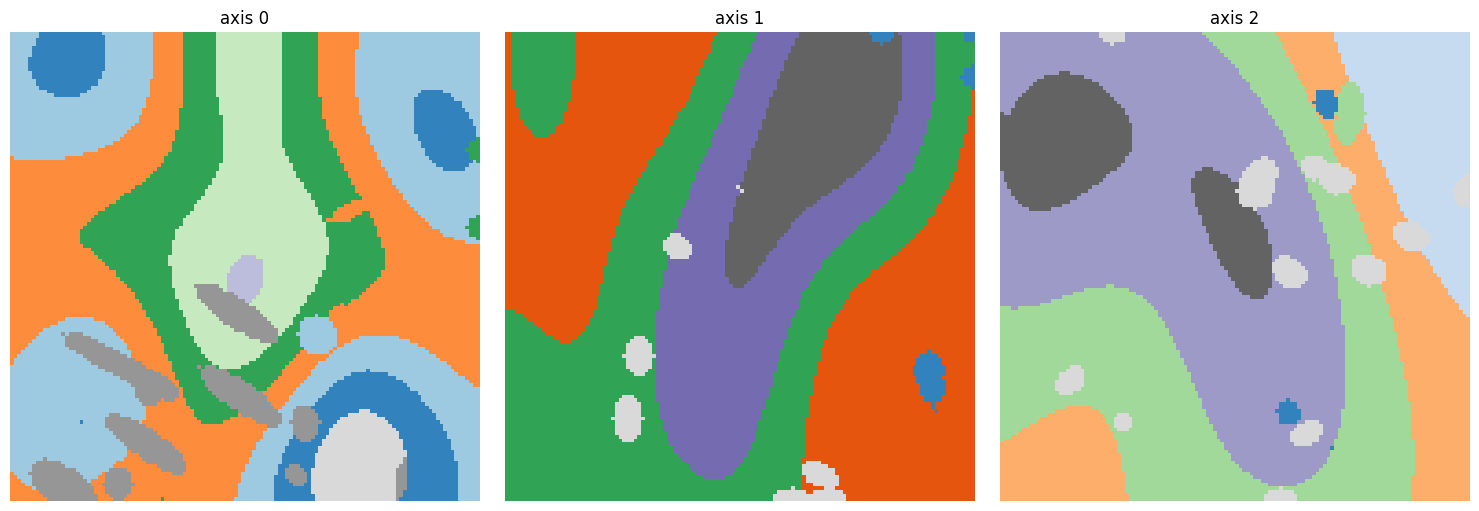

(<Figure size 1500x500 with 3 Axes>,
 [array([<AxesSubplot:title={'center':'axis 0'}>,
         <AxesSubplot:title={'center':'axis 1'}>,
         <AxesSubplot:title={'center':'axis 2'}>], dtype=object)])

In [23]:
shapes = draw_shapes_easy(shape = (param_3d.img_size_128,)*3,num_label=8)

shapes = tf.squeeze(shapes)
shapes = tf.cast(shapes, tf.int32)

bones = draw_bones_only(shape = (param_3d.img_size_128,)*3,num_labels=8,num_bones=20)
bones = tf.cast(bones, tf.int32)
bones = shift_non_zero_elements(bones,6)

shapes2 = draw_layer_elipses(shape=(param_3d.img_size_128,)*3, num_labels=8, num_shapes=50, sigma=2)
shapes2 = tf.squeeze(shapes2)
shapes2 = tf.cast(shapes2, tf.int32)
shapes2 = shift_non_zero_elements(shapes2,6)  
shapes2 = bones + shapes2 * tf.cast(bones == 0,tf.int32)
ne.plot.volume3D(sf.Volume(shapes2), cmaps=['tab20c'])

In [7]:
np.unique(shapes2)

array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
      dtype=int32)

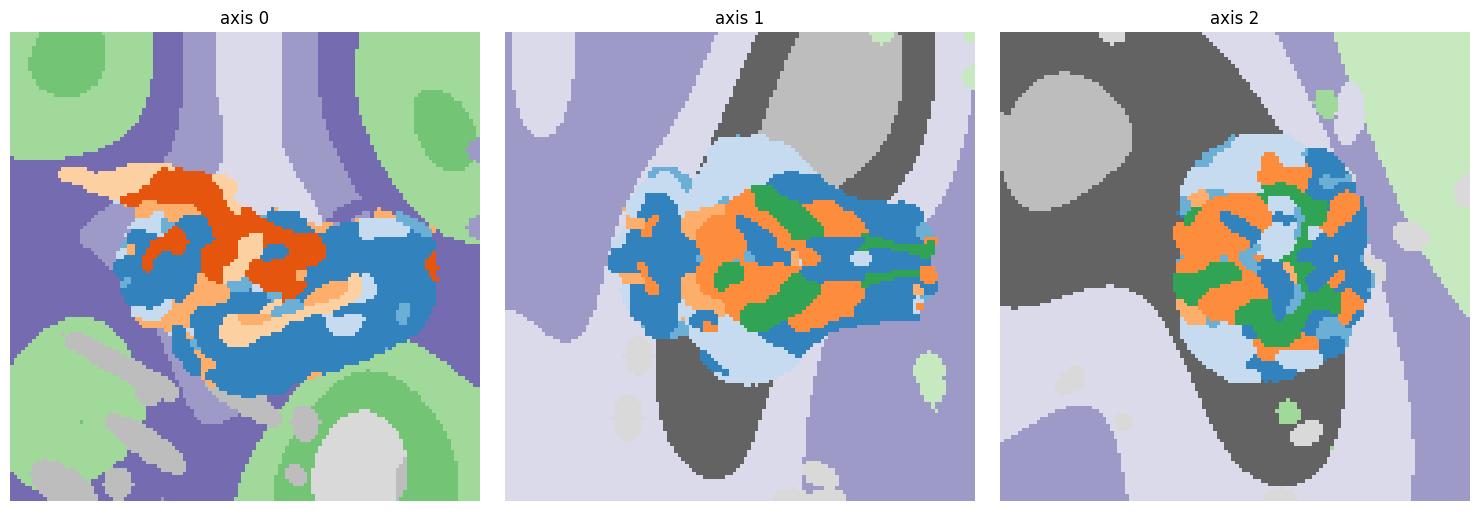

(<Figure size 1500x500 with 3 Axes>,
 [array([<AxesSubplot:title={'center':'axis 0'}>,
         <AxesSubplot:title={'center':'axis 1'}>,
         <AxesSubplot:title={'center':'axis 2'}>], dtype=object)])

In [24]:
import nibabel as nib
fg = masked_label_map
bg = shapes2
result = fg + bg * tf.cast(fg == 0,tf.int32)
ne.plot.volume3D(sf.Volume(result), cmaps=['tab20c'])
# nib.save(nib.Nifti1Image(result.numpy().astype(np.int32), np.eye(4)), os.path.join("synth_data", 'gmm.nii.gz'))

In [1]:
result.shape

NameError: name 'result' is not defined

Checking: '/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/template/anat.nii.gz'
[DEBUG] NiftiArrayIO.load(): no header extensions found!
Checking: '/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/template/anat_brain_olfactory_mask.nii.gz'
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[HMRF] Iteration 1/10
[HMRF] Iteration 2/10
[HMRF] Iteration 3/10
[HMRF] Iteration 4/10
[HMRF] Iteration 5/10
[HMRF] Iteration 6/10
[HMRF] Iteration 7/10
[HMRF] Iteration 8/10
[HMRF] Iteration 9/10
[HMRF] Iteration 10/10
[HMRF] Iteration 1/10
[HMRF] Iteration 2/10
[HMRF] Iteration 3/10
[HMRF] Iteration 4/10
[HMRF] Iteration 5/10
[HMRF] Iteration 6/10
[HMRF] Iteration 7/10
[HMRF] Iteration 8/10
[HMRF] Iteration 9/10
[HMRF] Iteration 10/10


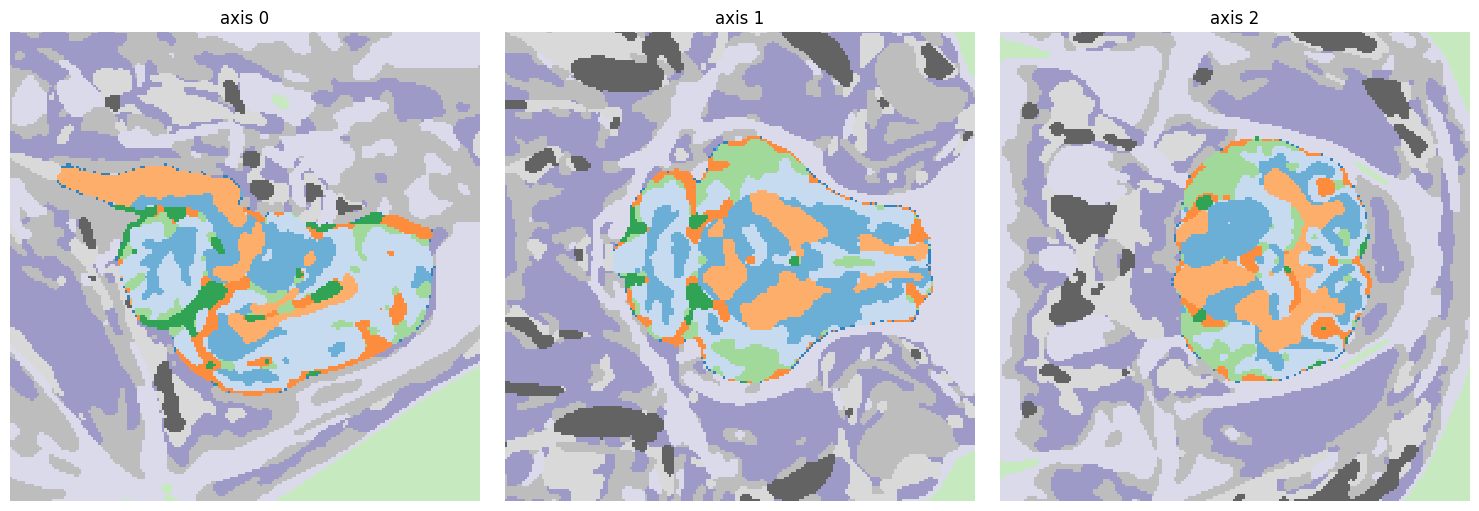

(<Figure size 1500x500 with 3 Axes>,
 [array([<AxesSubplot:title={'center':'axis 0'}>,
         <AxesSubplot:title={'center':'axis 1'}>,
         <AxesSubplot:title={'center':'axis 2'}>], dtype=object)])

In [12]:
from scipy.ndimage import zoom, gaussian_filter, binary_fill_holes
from hmrf_em import normalize, kmeans_init, run_hmrf_em
import numpy as np
import os
from utils import *
from help import *
def soften_labels_via_gaussian(label_map, sigma=1):
    n_classes = int(label_map.max()) + 1
    smoothed_probs = np.zeros((n_classes,) + label_map.shape)

    for c in range(n_classes):
        class_mask = (label_map == c).astype(float)
        smoothed_probs[c] = gaussian_filter(class_mask, sigma=sigma)

    softened = np.argmax(smoothed_probs, axis=0)
    return softened

scaling_factor = 1.0
def build_hmrf_label_map(k1=6, k2=6):
    # n_classes = k1
    beta = 0.5
    max_iter = 10
    sigma = 1.0  # smoothing before clustering

    folders_path = [
        "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/template/"
    ]

        #     "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/75",
        # "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/79-T2",
        # "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/79",
        # "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/78",
        # "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/106_6month/",
        # "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/82",
        # "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/101",
        # "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/93",


    
    predicted_anat_labels = []

    def load_volume_file(folder_path, file_name):
        for ext in ['.nii.gz', '.nii']:
            file_path = os.path.join(folder_path, file_name + ext)
            print(f"Checking: {repr(file_path)}")
            if os.path.exists(file_path):
                return sf.load_volume(file_path).reshape([param_3d.img_size_256] * 3).data
        raise FileNotFoundError(f"{file_name} not found in {folder_path}")

    for folder_path in folders_path:
        pig_anat = load_volume_file(folder_path, 'anat')
        pig_brain_mask = load_volume_file(folder_path, 'anat_brain_olfactory_mask')
        pig_brain_mask = (pig_brain_mask > 0).astype(np.uint8)

        # Preprocess
        sigma = 0.8
        pig_anat = gaussian_filter(pig_anat, sigma=sigma)
        pig_brain_mask = binary_fill_holes(pig_brain_mask)

        pig_anat = sf.Volume(zoom(pig_anat, scaling_factor, order=1)).reshape((256,) * 3).data
        pig_brain_mask = sf.Volume(zoom(pig_brain_mask, scaling_factor, order=1)).reshape((256,) * 3).data
        pig_brain_mask = binary_fill_holes(pig_brain_mask)

        # Brain region HMRF
        pig_brain = pig_anat * pig_brain_mask
        pig_brain = normalize(pig_brain.astype(np.float32))
        init_brain_labels = kmeans_init(pig_brain, pig_brain_mask, n_classes=k1)
        brain_seg = run_hmrf_em(pig_brain, pig_brain_mask, init_brain_labels, n_classes=k1, beta=beta, max_iter=max_iter)
        brain_seg = fill_holes_per_class(brain_seg)
        brain_seg = soften_labels_via_gaussian(brain_seg,sigma=0.8)
        
        # Non-brain region HMRF
        pig_skull = pig_anat.copy()
        pig_skull[pig_brain_mask == 1] = 0
        skull_mask = (pig_brain_mask == 0).astype(np.uint8)
        pig_skull = normalize(pig_skull.astype(np.float32))
        init_skull_labels = kmeans_init(pig_skull, skull_mask, n_classes=k2)
        skull_seg = run_hmrf_em(pig_skull, skull_mask, init_skull_labels, n_classes=k2, beta=beta, max_iter=max_iter)

        skull_seg = fill_holes_per_class(skull_seg)
        skull_seg = soften_labels_via_gaussian(skull_seg,sigma=0.8)
    

        # Combine brain and non-brain
        skull_seg[pig_brain_mask == 1] = 0
        skull_seg = shift_non_zero_elements(skull_seg, k1)
        final_seg = np.where(brain_seg > 0, brain_seg, skull_seg)

        # Final resizing
        zoomed_predicted_anat_labels = sf.Volume(final_seg).reshape([192] * 3)
        predicted_anat_labels.append(zoomed_predicted_anat_labels)

    return predicted_anat_labels

a= build_hmrf_label_map(6,6)
ne.plot.volume3D(a[0], cmaps=['tab20c'])

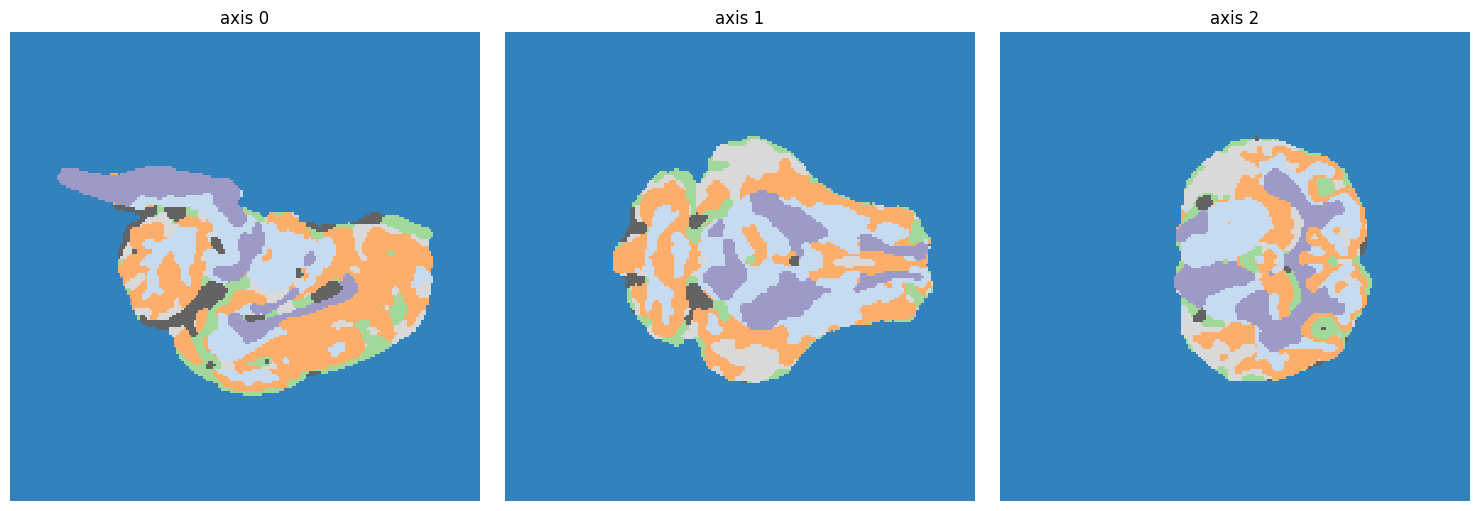

(<Figure size 1500x500 with 3 Axes>,
 [array([<AxesSubplot:title={'center':'axis 0'}>,
         <AxesSubplot:title={'center':'axis 1'}>,
         <AxesSubplot:title={'center':'axis 2'}>], dtype=object)])

In [13]:
masked_label_map = np.where((a[0].data >= 1) & 
                            (a[0].data <= 6),
                            a[0].data,
                            0)
ne.plot.volume3D(sf.Volume(masked_label_map), cmaps=['tab20c'])